## Control Variables
- Resolution = 0.25
- ROBOT_RADIUS = 0.25
- REGION = 8

- Vary num_of agent
- Vary Samples
- Vary Dataset 

In [1]:
import BayesianOptimisation.expGrid as expGrid
import BayesianOptimisation.expVoronoi as expVoronoi
import BayesianOptimisation.bo2VoronoiDirected as bo2VoronoiDirected
import BayesianOptimisation.experiment_setup as experiment
from core.DataStructure import *

from importlib import reload
import numpy as np
import pandas as pd
import seaborn as sb
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import Rectangle
import copy
import time
import os
import itertools

from scipy.optimize import minimize, Bounds
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, Reshape
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split

np.random.seed(9)
COLOUR = itertools.cycle(['#00FFFF', '#6495ED', '#89CFF0', '#0000FF', '#7393B3', '#088F8F', 
                          '#0096FF', '#0047AB', '#00FFFF', '#00008B', '#6F8FAF',
                          '#1434A4', '#7DF9FF', '#6082B6', '#00A36C', '#5D3FD3',
                          '#ADD8E6'])
# reload(bo2VoronoiDirected)

### Generating Data

In [2]:
# def getCoverage(exp, G, directed = False):
#     total_area = 0
#     total_dist = 0
#     assigned = {}
#     fig, ax = plt.subplots(figsize=(6,6))
#     plt.xlim(0,34)
#     plt.ylim(0,34)
#     count = 0
#     for n in G.nodes:
#         for e in G.neighbors(n):
#             if n != e and frozenset((n, e)) not in assigned.keys():
                
#                 p1 = G.nodes[n]['position']
#                 p2 = G.nodes[e]['position']
                
#                 if (directed):
#                     d = G.edges[n,e,0]['distance']
#                     c = G.edges[n,e,0]['capacity']
#                 else:
#                     d = G.edges[n,e]['distance']
#                     c = G.edges[n,e]['capacity']
                
                
#                 assigned[frozenset((n, e))] = 1

#                 adjustp1 = Point(p1.y, p1.x)
#                 adjustp2 = Point(p2.y, p2.x)

#                 refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
#                 refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

#                 if refpt1.x >= refpt2.x:
#                     theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
#                 else:
#                     theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

#                 if theta_rot >= np.pi/2:
#                     theta = theta_rot - np.pi/2
#                 else:
#                     theta = theta_rot + np.pi/2

#                 dy = -(c/2)*np.sin(theta)
#                 if refpt1.y == refpt2.y:
#                     dx = 0
#                     width = d
#                     height = c
#                     a = 0
#                 elif refpt1.x > refpt2.x:
#                     dx = -(c/2)*np.cos(theta)
#                     width = c
#                     height = d
#                     a = (theta) * 180 / np.pi
#                 elif refpt1.x == refpt2.x:
#                     dx = -(c/2)
#                     width = c
#                     height = d
#                     a = 0
#                 else:
#                     dx = (c/2)*np.cos(np.pi - theta)
#                     width = d
#                     height = c
#                     a = (theta_rot) * 180 / np.pi
                    

#                 rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = 'black')
#                 plt.gca().add_patch(rect)
#                 count +=1

#     for o in exp.obstacles_loc:
#         adjustedx, adjustedy = o[1],o[0]
#         rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
#         plt.gca().add_patch(rect)

#     ax.axis('off')

#     im = fig
#     im.canvas.draw()
#     X = np.array(im.canvas.renderer._renderer)
#     X_reshape = X.reshape((-1,4))
#     X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
#     black = np.count_nonzero(X_reshape == 0)
#     white= np.count_nonzero(X_reshape == 255)
# #     print("Black px", black, "White px", white)
#     percentage = black/(white+black)
#     return percentage

In [3]:
# Updated Get Coverage, take into account of obs now
def getCoverage(exp, G, directed = False, save_fig_path = None):
    total_area = 0
    total_dist = 0
    assigned = {}
    fig, ax = plt.subplots(figsize=(6,6))
    plt.xlim(0,exp.image.shape[1])
    plt.ylim(0,exp.image.shape[0])
    count = 0
    
    for o in exp.obstacles_loc:
        adjustedx, adjustedy = o[1],o[0]
        rect = Rectangle((adjustedx-0.5,adjustedy-0.5),1,1,linewidth=0.1,fill=True, angle = 0, color = 'black')
        plt.gca().add_patch(rect)
    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    obs_black = np.count_nonzero(X_reshape == 0)
#     print("Obstacle Black", obs_black)
    
    for n in G.nodes:
        for e in G.neighbors(n):
            if n != e and frozenset((n, e)) not in assigned.keys():
                
                p1 = G.nodes[n]['position']
                p2 = G.nodes[e]['position']
                
                if (directed):
                    d = G.edges[n,e,0]['distance']
                    c = G.edges[n,e,0]['capacity']*exp.ROBOT_RADIUS
                else:
                    d = G.edges[n,e]['distance']
                    c = G.edges[n,e]['capacity']*exp.ROBOT_RADIUS
                
                
                assigned[frozenset((n, e))] = 1

                adjustp1 = Point(p1.y, p1.x)
                adjustp2 = Point(p2.y, p2.x)

                refpt1 = adjustp1 if adjustp1.y <= adjustp2.y else adjustp2
                refpt2 = adjustp1 if adjustp1.y > adjustp2.y else adjustp2

                if refpt1.x >= refpt2.x:
                    theta_rot = np.pi - np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))
                else:
                    theta_rot = np.arctan(abs(refpt1.y - refpt2.y)/abs(refpt1.x - refpt2.x))

                if theta_rot >= np.pi/2:
                    theta = theta_rot - np.pi/2
                else:
                    theta = theta_rot + np.pi/2

                dy = -(c/2)*np.sin(theta)
                if refpt1.y == refpt2.y:
                    dx = 0
                    width = d
                    height = c
                    a = 0
                elif refpt1.x > refpt2.x:
                    dx = -(c/2)*np.cos(theta)
                    width = c
                    height = d
                    a = (theta) * 180 / np.pi
                elif refpt1.x == refpt2.x:
                    dx = -(c/2)
                    width = c
                    height = d
                    a = 0
                else:
                    dx = (c/2)*np.cos(np.pi - theta)
                    width = d
                    height = c
                    a = (theta_rot) * 180 / np.pi
                    
                print_colour = 'blue' if save_fig_path != None else 'black'
                rect = Rectangle((refpt1.x+dx,refpt1.y+dy),width,height,linewidth=0.1,fill=True, angle = a,color = print_colour )
                plt.gca().add_patch(rect)
                count +=1

    ax.axis('off')
    if save_fig_path != None:
        plt.savefig(save_fig_path)

    im = fig
    im.canvas.draw()
    X = np.array(im.canvas.renderer._renderer)
    X_reshape = X.reshape((-1,4))
    X_reshape = np.delete(X_reshape, [1,2,3], axis = 1)
    black = np.count_nonzero(X_reshape == 0)
    white= np.count_nonzero(X_reshape == 255)
#     print("Black px", black, "White px", white)
    percentage = (black-obs_black)/(white+black-obs_black)
#     print("U2", percentage)
    return percentage

In [4]:
# def showAccSolution(result_graph, paths, image, nodes, start_nodes, end_nodes, all_path = True, path_num = 0, save_fig_path = None):
#     edges_in_path = []
#     image2 = 1-image
#     fig, ax = plt.subplots(figsize=(12,12))
#     img = np.array(1-image)
#     ax = sb.heatmap(img)
#     assigned = {}
    
#     for index, path in enumerate(paths):
# #         path = paths[path_num]
#         for ite in range(len(path)-1):
#             edges_in_path.append(np.array([path[ite],path[ite+1],0]))
#             p1 = result_graph.nodes[path[ite]]['position']
#             p2 = result_graph.nodes[path[ite+1]]['position']

#             for r in (p1.x, p2.x, 1):
#                 for c in (p1.y, p2.y, 1):
#                     if (Point(r,c) in np.array(nodes)[end_nodes]):
#                         image2[int(r),int(c)] = 1
#                     else:
#                         image2[int(r),int(c)] += 0.2

#         drawn = {}
#         loop = result_graph.edges if all_path else edges_in_path

#         for elem in loop:
#             cur = result_graph.edges[elem[0], elem[1], 0]['probability']
#             opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
#             unused = 1 - cur - opposite
#             scaler = 0.7
#             if cur > opposite:
#                 p1 = result_graph.nodes[elem[0]]['position']
#                 arr1 = np.array([p1.x,p1.y])
#                 p2 = result_graph.nodes[elem[1]]['position']
#                 arr2 = np.array([p2.x,p2.y])
#                 direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
#                 mag = np.linalg.norm(arr2 - arr1)*scaler
#                 dx, dy = mag*direction
#             else:
#                 p1 = result_graph.nodes[elem[1]]['position']
#                 arr1 = np.array([p1.x,p1.y])
#                 p2 = result_graph.nodes[elem[0]]['position']
#                 arr2 = np.array([p2.x,p2.y])
#                 direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
#                 mag = np.linalg.norm(arr2 - arr1)*scaler
#                 dx, dy = mag*direction
            
#             # only draw arrow once
#             if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
#                 plt.arrow(p1.y, p1.x, dy, dx, head_width = 0.35, alpha=0.9, color = 'grey', linewidth=1)
#                 assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            
# #         p = start_nodes[index]
# #         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
# #         p = end_nodes[index]
# #         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)
# #         name = './results/vordir_path'+ str(path_num)+'.png'
# #         plt.gca().invert_yaxis()
# #         plt.savefig(name)
        
#     for p in start_nodes:
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'red', linewidths=5)
#     for p in end_nodes:
#         plt.scatter(nodes[p].y, nodes[p].x, color = 'lime', linewidths=5)

# #     name = './data/'+ 'ANN' +'.png'
#     plt.gca().invert_yaxis()
#     plt.savefig(save_fig_path)
#     return fig

In [5]:
def showVorDirSolution(
    result_graph, 
    paths,
    exp,
    save_fig_path = None):
    
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    assigned = {}
    scaler = 0.2
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys():
            head_width = 0.1 if mag < 0.2 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
        
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [6]:
def showVorDirSolutionPath(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path

        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=80, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [7]:
def showVorDirSolutionAcc(
    result_graph, 
    paths, image, 
    nodes, 
    start_nodes, 
    end_nodes, 
    all_path = True, 
    path_num = 0,
    save_fig_path = None, 
    exp=None):
    
    image2 = 1-image
    fig, ax = plt.subplots(figsize=(12,12))
    img = np.array(1-exp.image)
    ax = sb.heatmap(img)
    colors = copy.deepcopy(COLOUR)
    
    edges_in_path = []
    assigned = {}
    drawn = {}
    
    for index, path in enumerate(paths):
        colour = next(colors)
        for ite in range(len(path)-1):
            edges_in_path.append(np.array([path[ite],path[ite+1],0]))
            p1 = result_graph.nodes[path[ite]]['position']
            p2 = result_graph.nodes[path[ite+1]]['position']

            for r in (p1.x, p2.x, 1):
                for c in (p1.y, p2.y, 1):
                    if (Point(r,c) in np.array(nodes)[end_nodes]):
                        image2[int(r),int(c)] = 1
                    else:
                        image2[int(r),int(c)] += 0.2

        loop = result_graph.edges if all_path else edges_in_path
        for elem in loop:
            cur = result_graph.edges[elem[0], elem[1], 0]['probability']
            opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
            unused = 1 - cur - opposite
            scaler = 0.8
            if cur > opposite:
                p1 = result_graph.nodes[elem[0]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[1]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            else:
                p1 = result_graph.nodes[elem[1]]['position']
                arr1 = np.array([p1.x,p1.y])
                p2 = result_graph.nodes[elem[0]]['position']
                arr2 = np.array([p2.x,p2.y])
                direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
                mag = np.linalg.norm(arr2 - arr1)*scaler
                dx, dy = mag*direction
            
            # only draw arrow once
            if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
                head_width = 0.1 if mag < 0.2 else 0.35
                plt.plot([p1.y,p2.y], [p1.x, p2.x],color = colour, linewidth=1)
                plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = colour, linewidth=0.1)
                assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
                drawn[frozenset([elem[0], elem[1]])] = 1
                
    #draw all other arrow
    scaler = 0.8
    for elem in result_graph.edges:
        cur = result_graph.edges[elem[0], elem[1], 0]['probability']
        opposite = result_graph.edges[elem[1], elem[0], 0]['probability']
        if cur > opposite:
            p1 = result_graph.nodes[elem[0]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[1]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction
        else:
            p1 = result_graph.nodes[elem[1]]['position']
            arr1 = np.array([p1.x,p1.y])
            p2 = result_graph.nodes[elem[0]]['position']
            arr2 = np.array([p2.x,p2.y])
            direction = (arr2-arr1) / np.linalg.norm(arr2 - arr1)
            mag = np.linalg.norm(arr2 - arr1)*scaler
            dx, dy = mag*direction

        # only draw arrow once
        if frozenset((p1.y, p1.x, dy, dx)) not in assigned.keys() and frozenset([elem[0], elem[1]]) not in drawn:
            head_width = 0.1 if mag < 0.5 else 0.35
            plt.plot([p1.y,p2.y], [p1.x, p2.x],color = "grey", linewidth=1)
            plt.arrow(p1.y, p1.x, dy, dx, head_width = head_width, alpha=0.9, color = "grey", linewidth=0.1)
            assigned[frozenset((p1.y, p1.x, dy, dx))] = 1
            drawn[frozenset([elem[0], elem[1]])] = 1
        
    for p in exp.start_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='none', edgecolors='r')
    for p in exp.end_nodes:
        plt.scatter(exp.nodes[p].y, exp.nodes[p].x, s=120, facecolors='r', edgecolors='r')

    plt.gca().invert_yaxis()
    plt.savefig(save_fig_path)

In [8]:
final_result_path =  "./data/BO/final_result.csv"
results_array = []
OBJECTIVE = "Both"
# agent_list = [4,8,12]
agent_list = [4,8]
mapp = 'lak105d'

Successfully created the directory ./data/BO/4agent/Samples10/Dataset3/ 
Set Hyper Parameters, solving for 4 agents
num acquisition: 1, time elapsed: 0.76s
num acquisition: 2, time elapsed: 1.36s
num acquisition: 3, time elapsed: 2.12s
num acquisition: 4, time elapsed: 2.74s
Use CBS with Subgraph
Use CBS with Subgraph
Successfully created the directory ./data/BO/4agent/Samples50/Dataset3/ 
Set Hyper Parameters, solving for 4 agents
num acquisition: 1, time elapsed: 0.49s
num acquisition: 2, time elapsed: 0.97s
num acquisition: 3, time elapsed: 1.45s
num acquisition: 4, time elapsed: 1.93s
num acquisition: 5, time elapsed: 2.37s
num acquisition: 6, time elapsed: 2.86s
num acquisition: 7, time elapsed: 3.52s
num acquisition: 8, time elapsed: 4.00s
num acquisition: 9, time elapsed: 4.44s
num acquisition: 10, time elapsed: 4.92s
num acquisition: 11, time elapsed: 5.37s
num acquisition: 12, time elapsed: 5.88s
num acquisition: 13, time elapsed: 6.36s
num acquisition: 14, time elapsed: 6.94s

num acquisition: 117, time elapsed: 663.07s
num acquisition: 118, time elapsed: 667.26s
num acquisition: 119, time elapsed: 672.31s
num acquisition: 120, time elapsed: 677.02s
num acquisition: 121, time elapsed: 681.73s
num acquisition: 122, time elapsed: 687.00s
num acquisition: 123, time elapsed: 691.35s
num acquisition: 124, time elapsed: 696.22s
num acquisition: 125, time elapsed: 710.49s
num acquisition: 126, time elapsed: 725.57s
num acquisition: 127, time elapsed: 738.46s
num acquisition: 128, time elapsed: 750.95s
num acquisition: 129, time elapsed: 756.36s
num acquisition: 130, time elapsed: 761.10s
num acquisition: 131, time elapsed: 765.68s
num acquisition: 132, time elapsed: 770.57s
num acquisition: 133, time elapsed: 775.31s
num acquisition: 134, time elapsed: 780.30s
num acquisition: 135, time elapsed: 784.98s
num acquisition: 136, time elapsed: 789.40s
num acquisition: 137, time elapsed: 797.21s
num acquisition: 138, time elapsed: 813.42s
num acquisition: 139, time elaps

num acquisition: 29, time elapsed: 232.50s
num acquisition: 30, time elapsed: 237.88s
num acquisition: 31, time elapsed: 242.90s
num acquisition: 32, time elapsed: 248.37s
num acquisition: 33, time elapsed: 260.60s
num acquisition: 34, time elapsed: 277.76s
num acquisition: 35, time elapsed: 294.02s
num acquisition: 36, time elapsed: 308.63s
num acquisition: 37, time elapsed: 326.14s
num acquisition: 38, time elapsed: 341.05s
num acquisition: 39, time elapsed: 357.59s
num acquisition: 40, time elapsed: 362.10s
num acquisition: 41, time elapsed: 366.76s
num acquisition: 42, time elapsed: 371.85s
num acquisition: 43, time elapsed: 376.46s
num acquisition: 44, time elapsed: 381.17s
num acquisition: 45, time elapsed: 385.31s
num acquisition: 46, time elapsed: 392.99s
num acquisition: 47, time elapsed: 401.28s
num acquisition: 48, time elapsed: 407.90s
num acquisition: 49, time elapsed: 413.16s
num acquisition: 50, time elapsed: 417.40s
num acquisition: 51, time elapsed: 421.51s
num acquisi

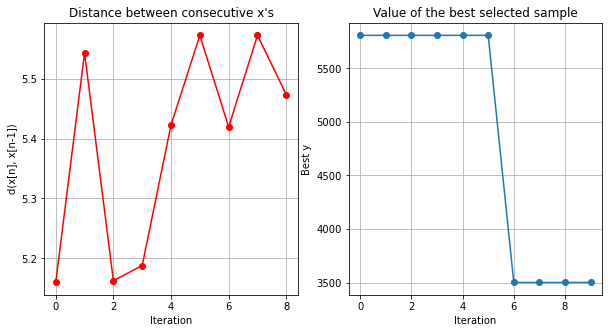

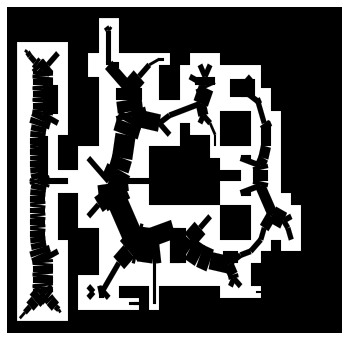

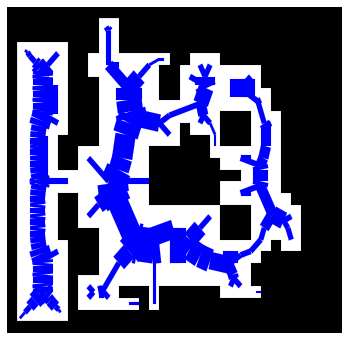

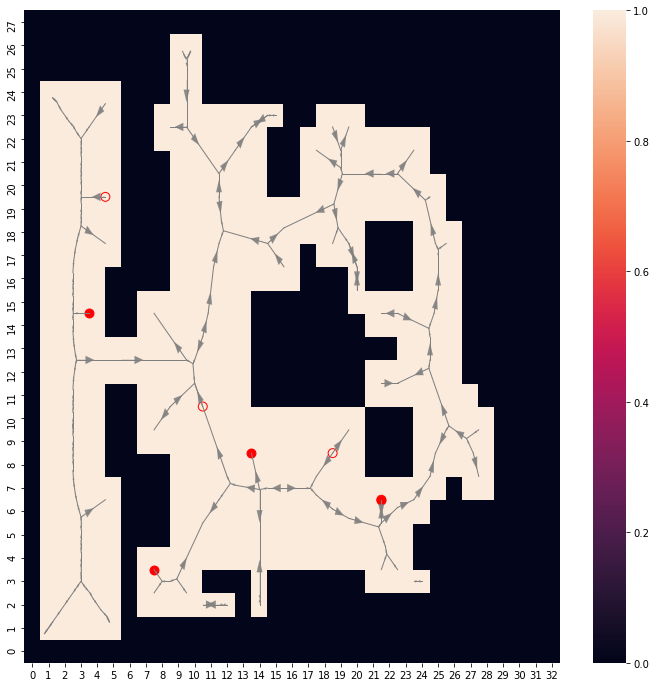

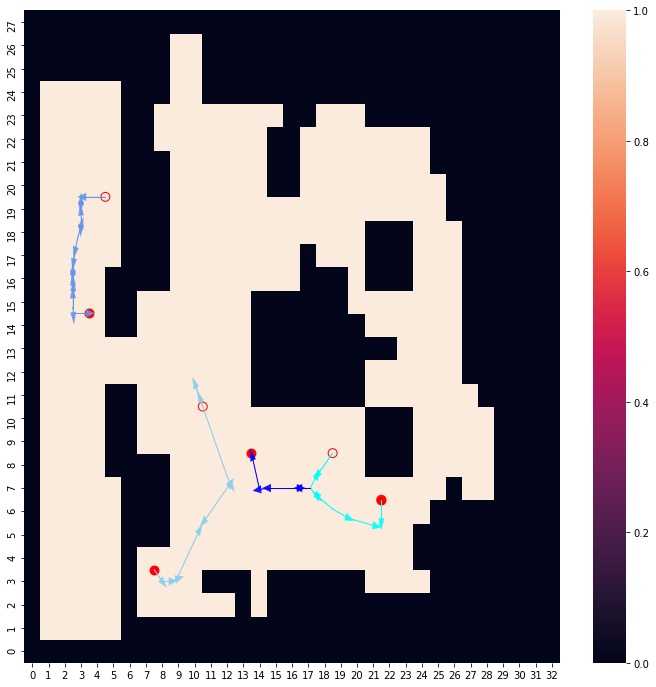

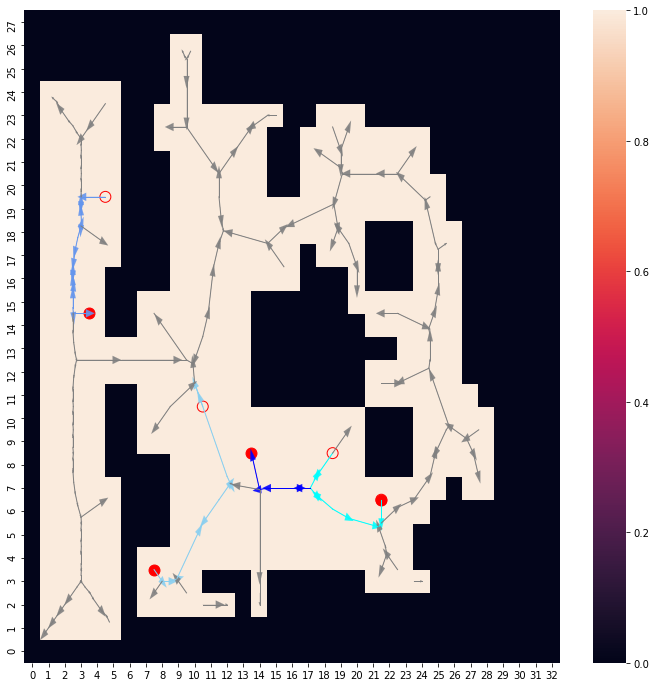

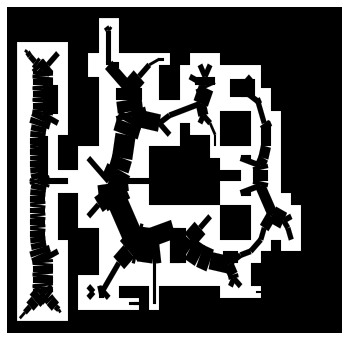

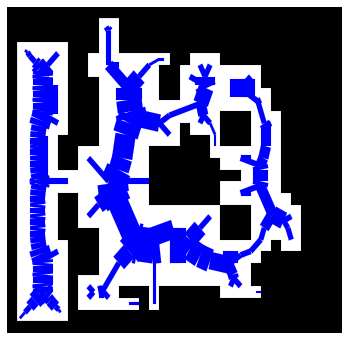

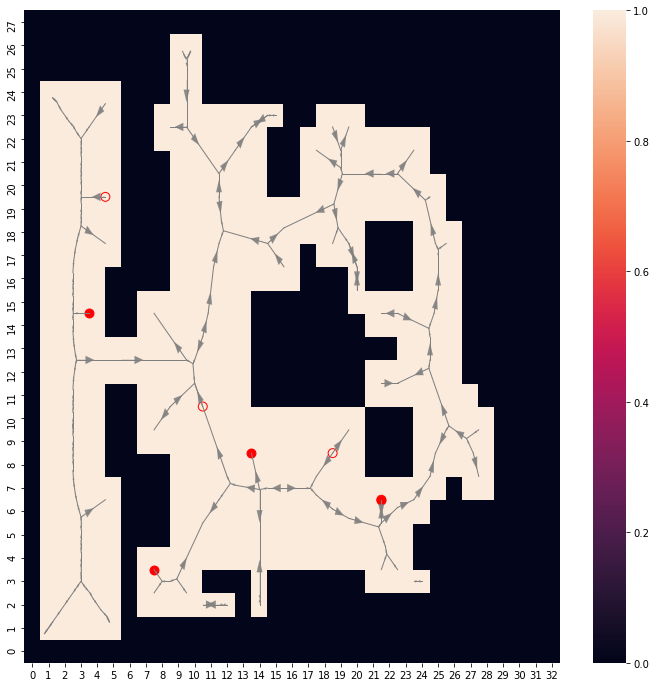

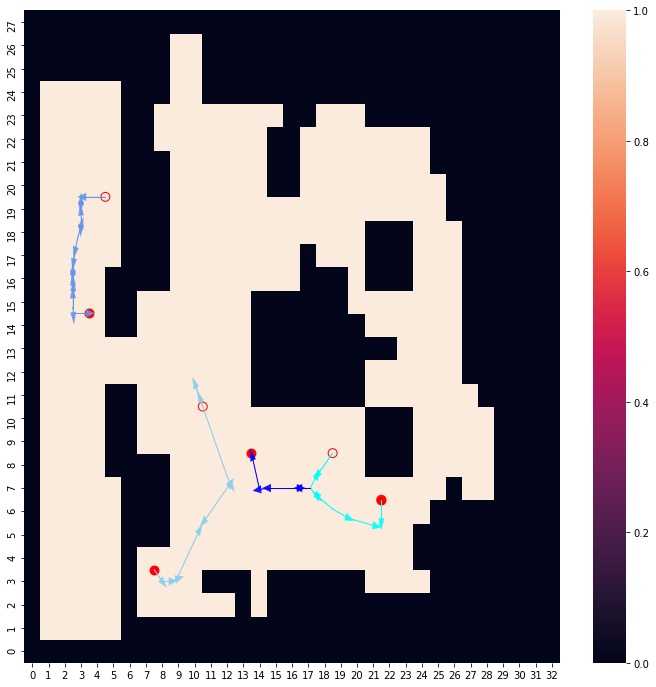

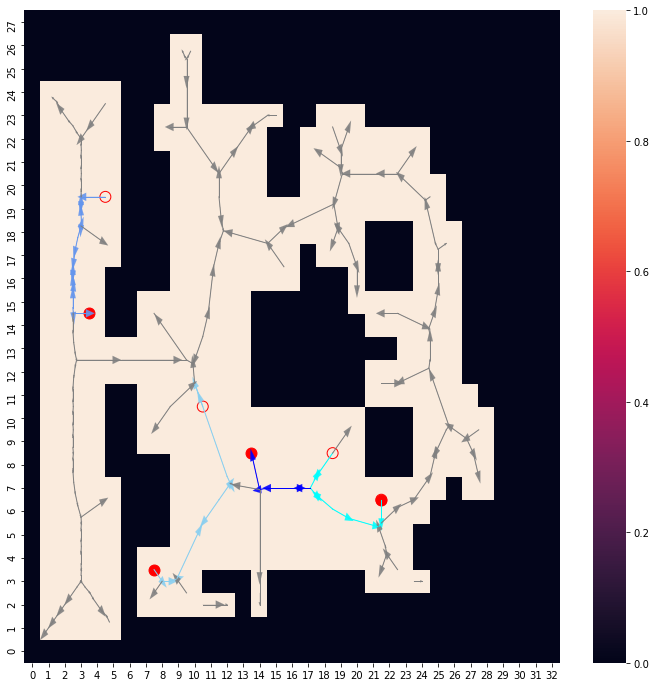

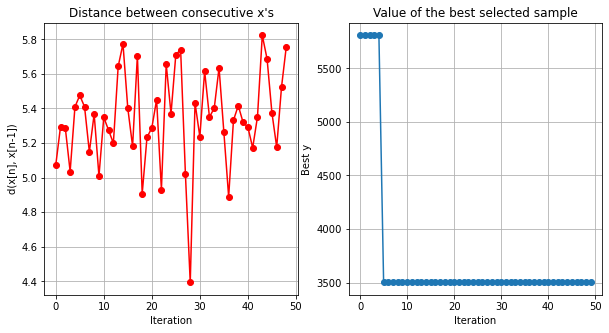

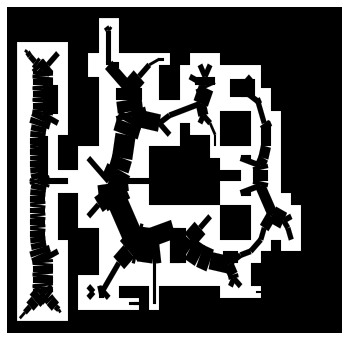

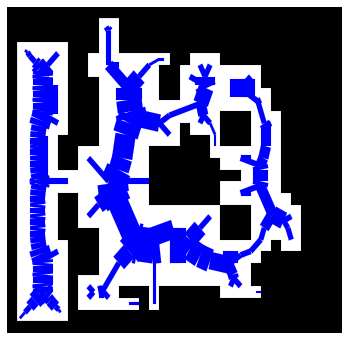

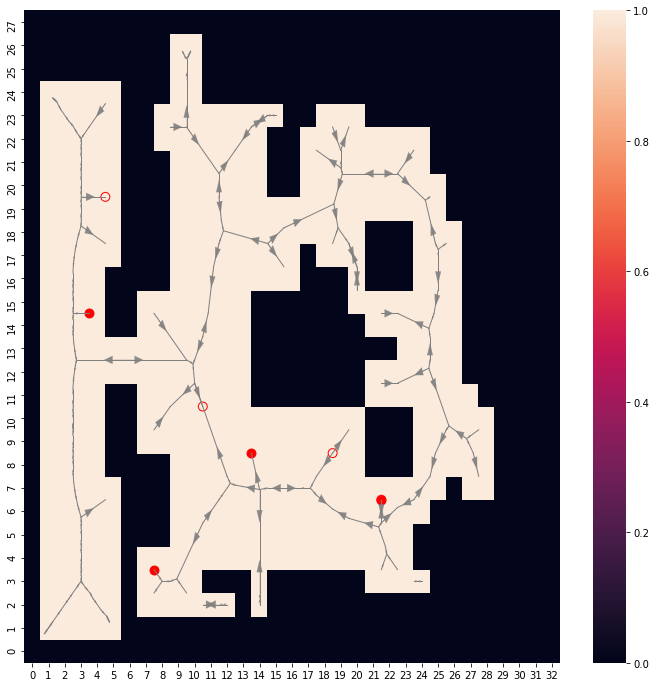

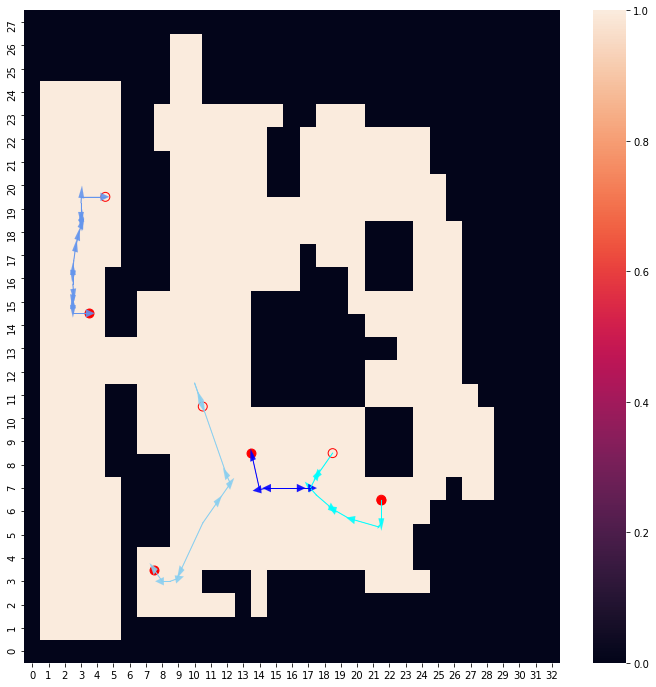

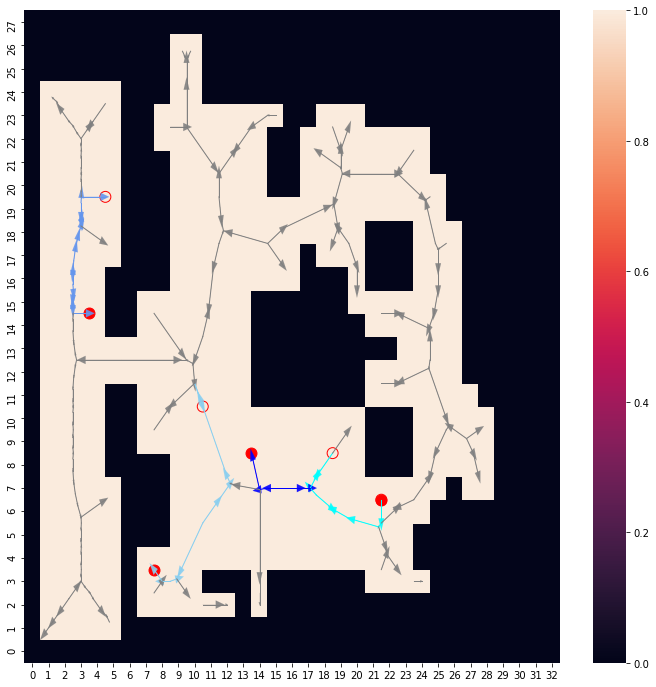

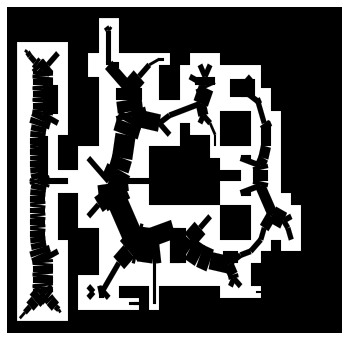

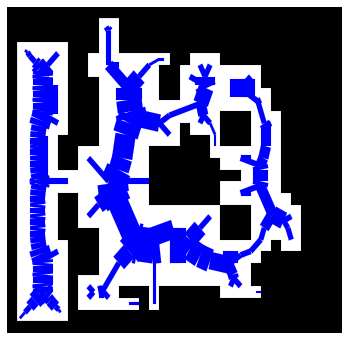

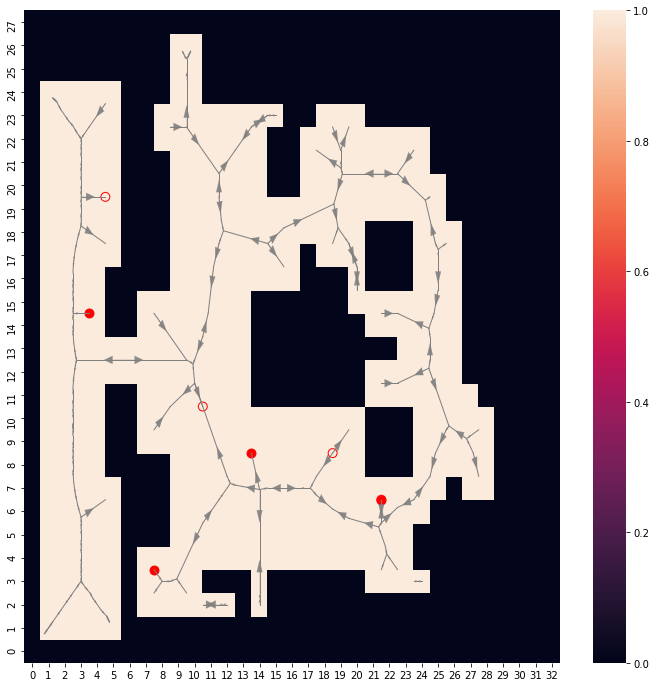

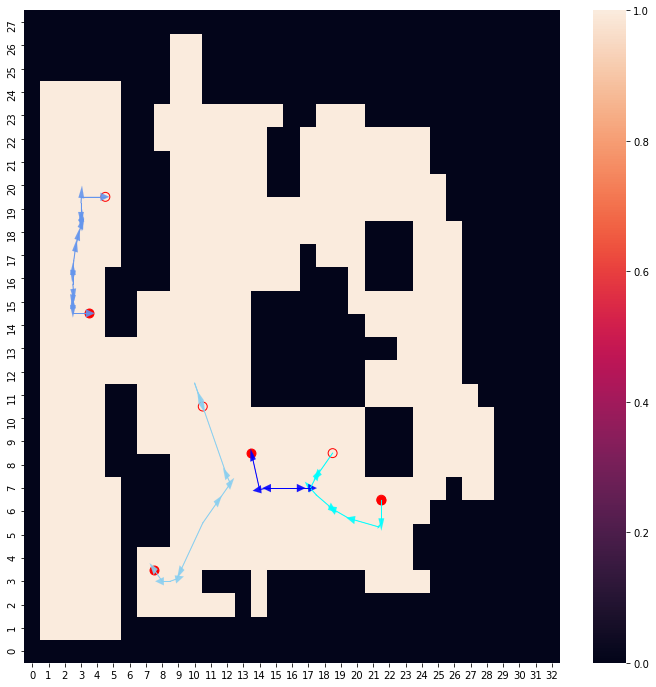

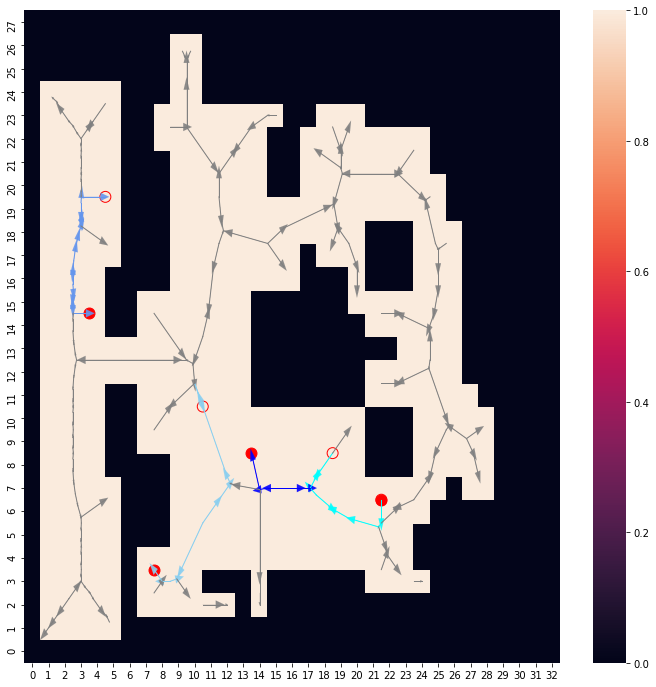

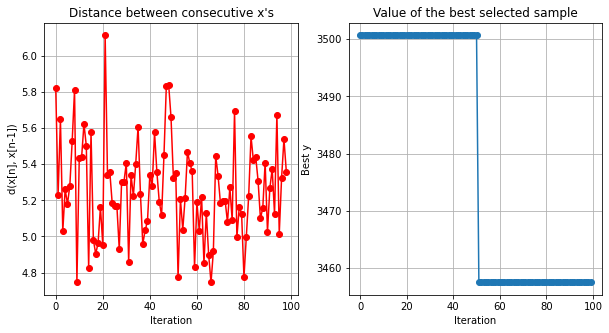

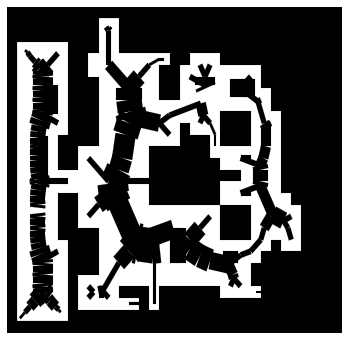

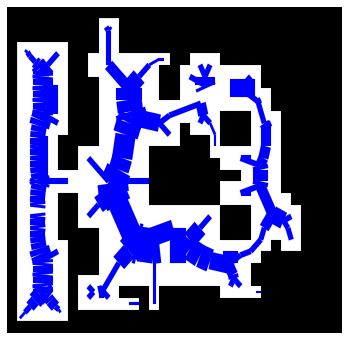

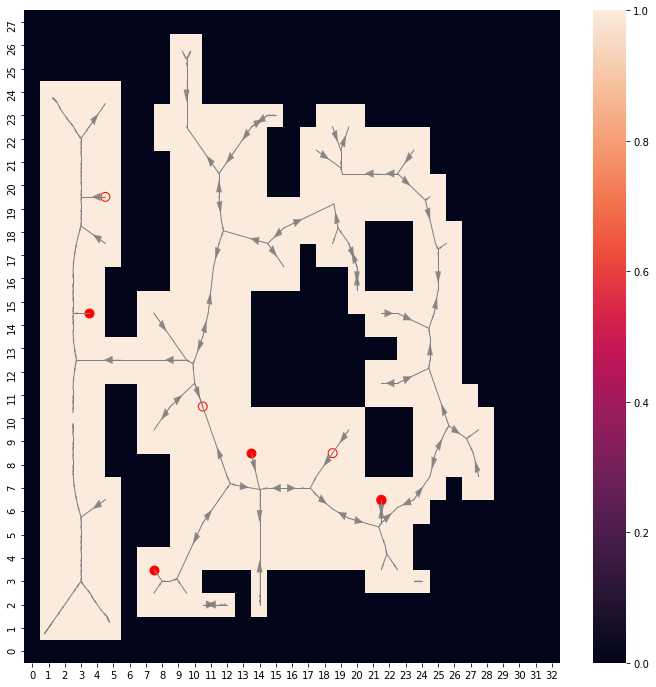

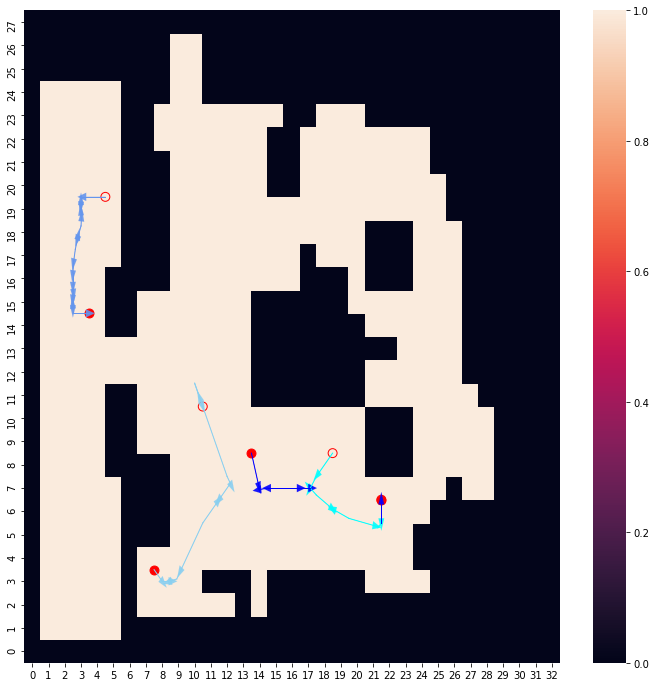

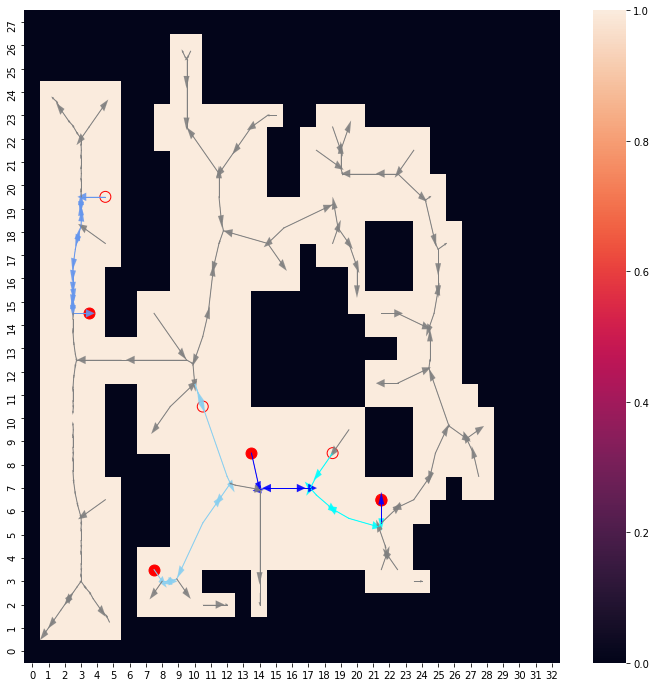

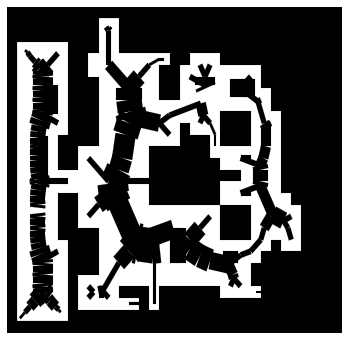

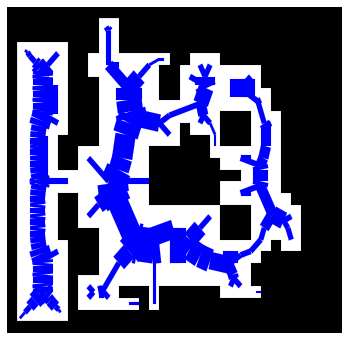

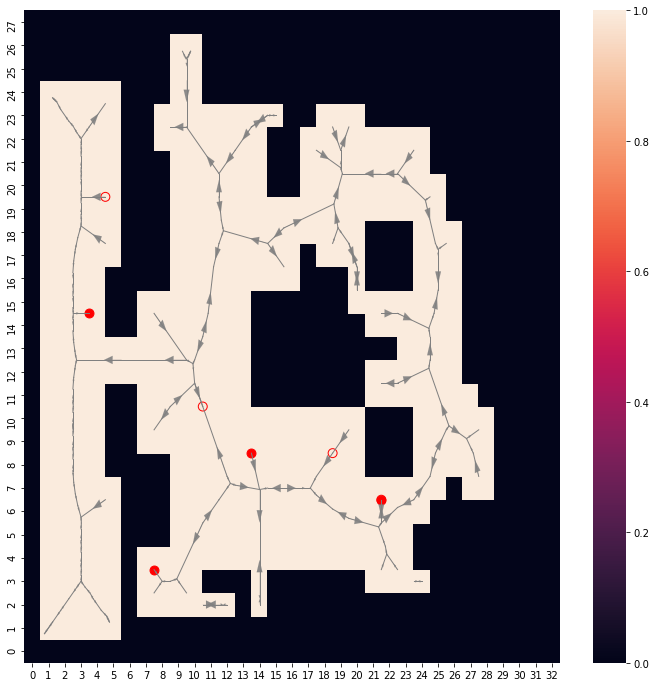

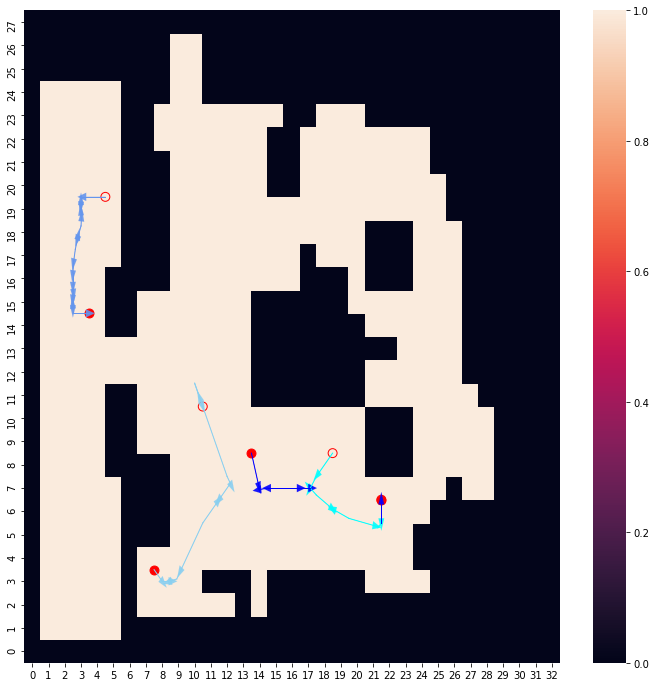

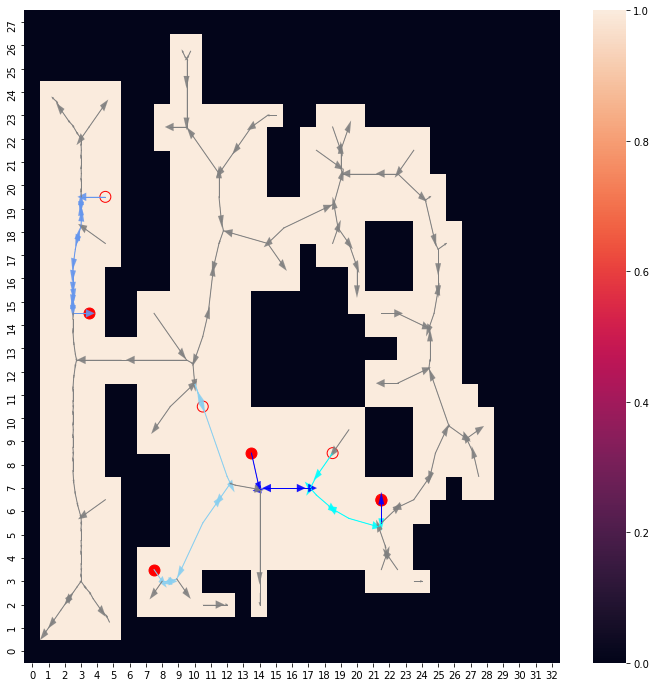

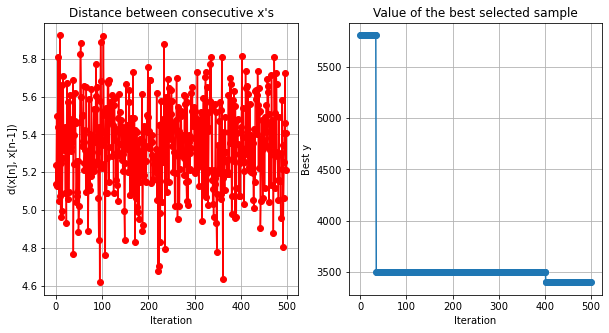

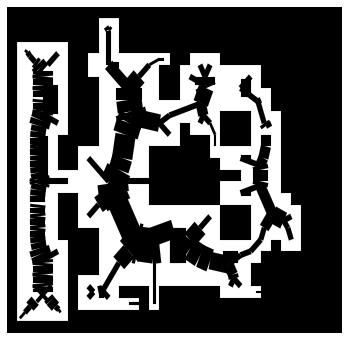

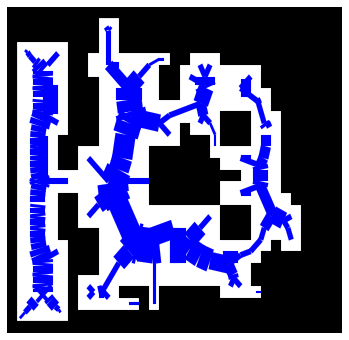

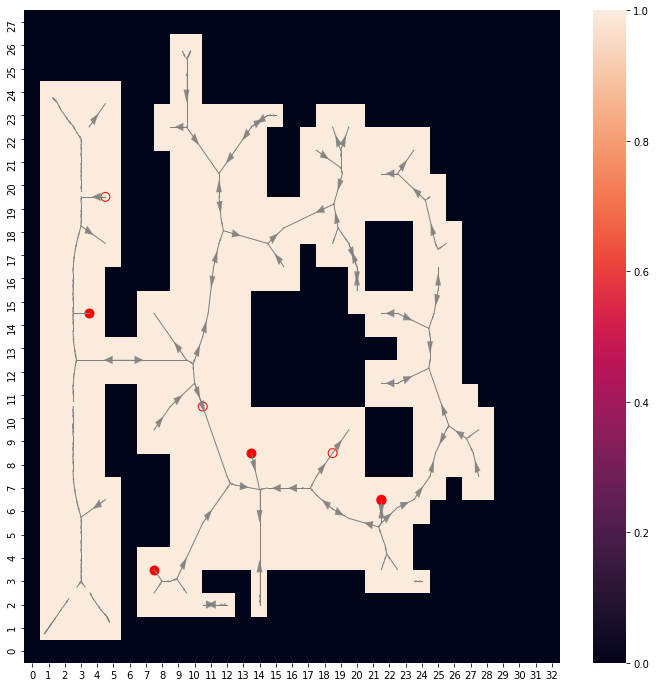

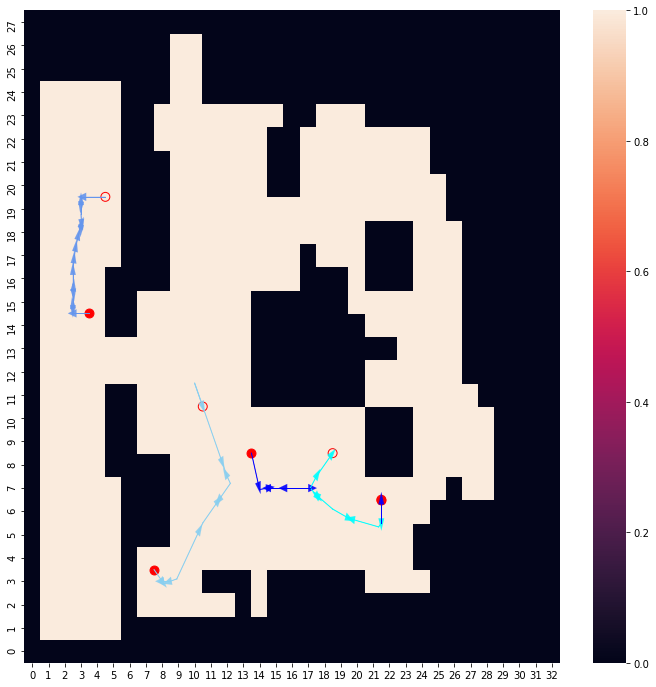

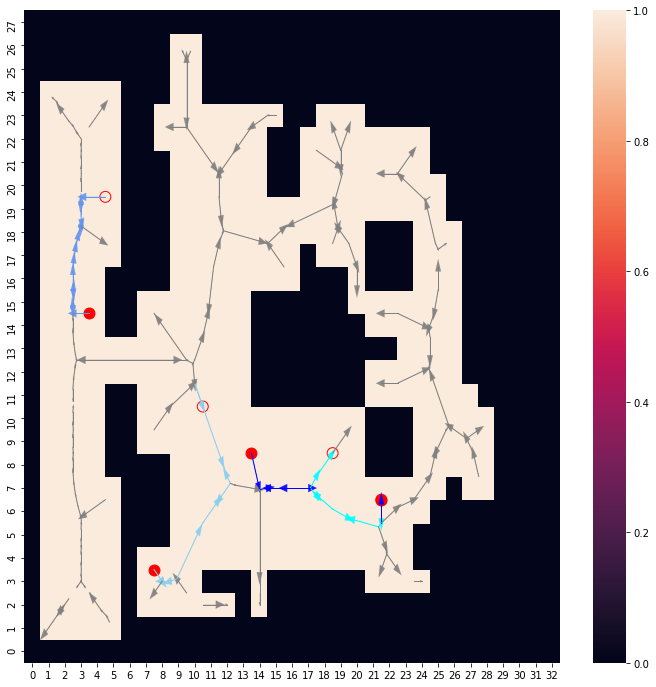

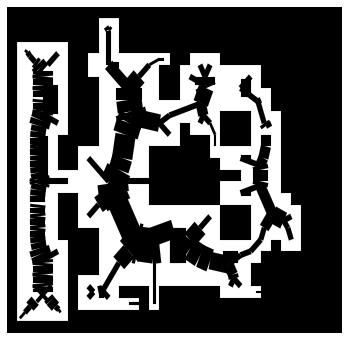

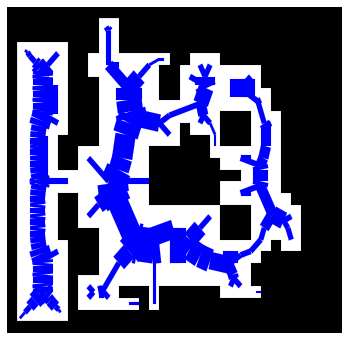

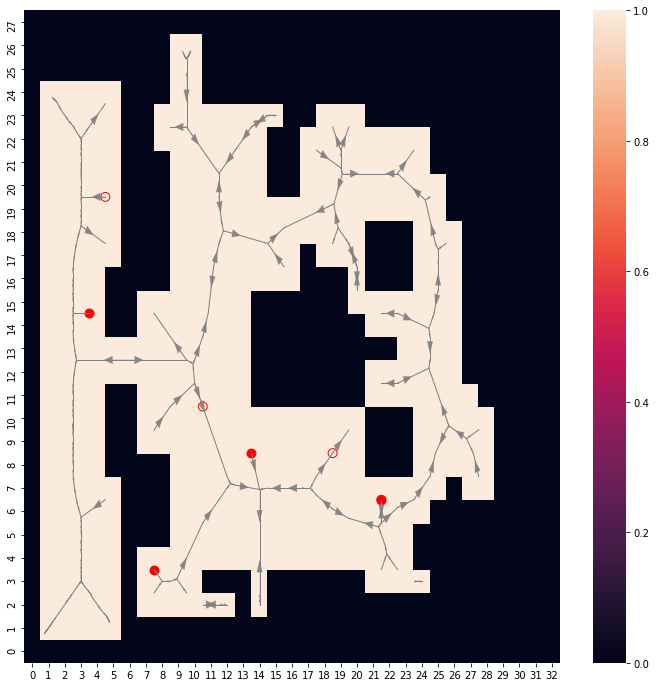

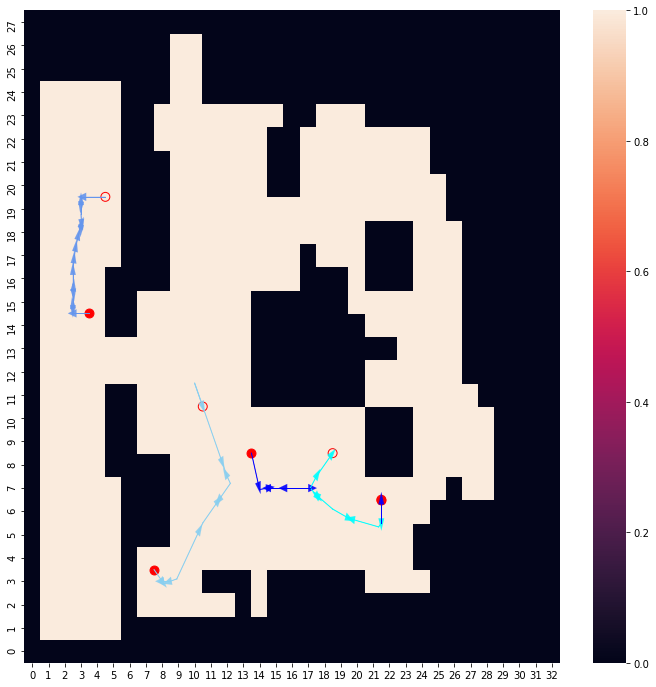

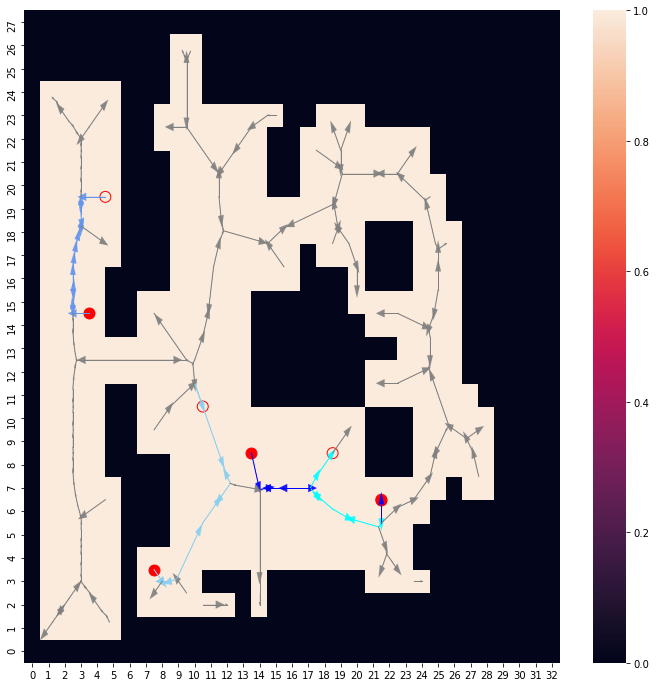

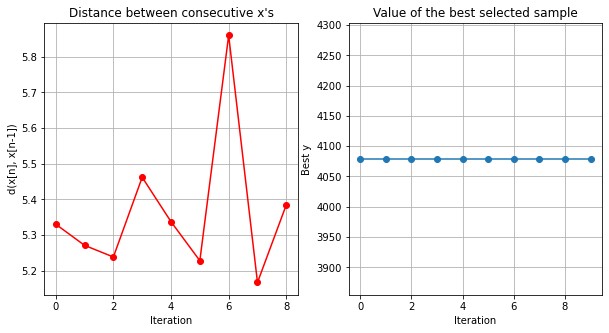

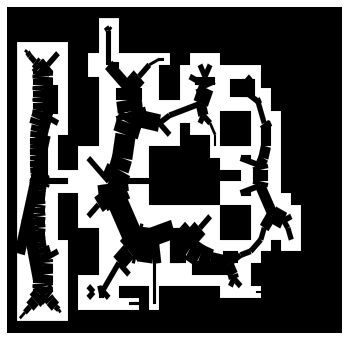

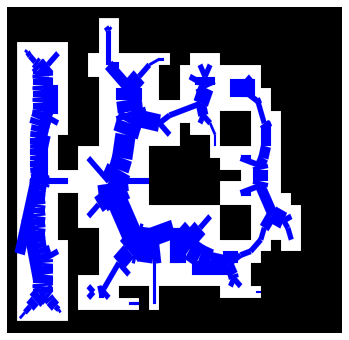

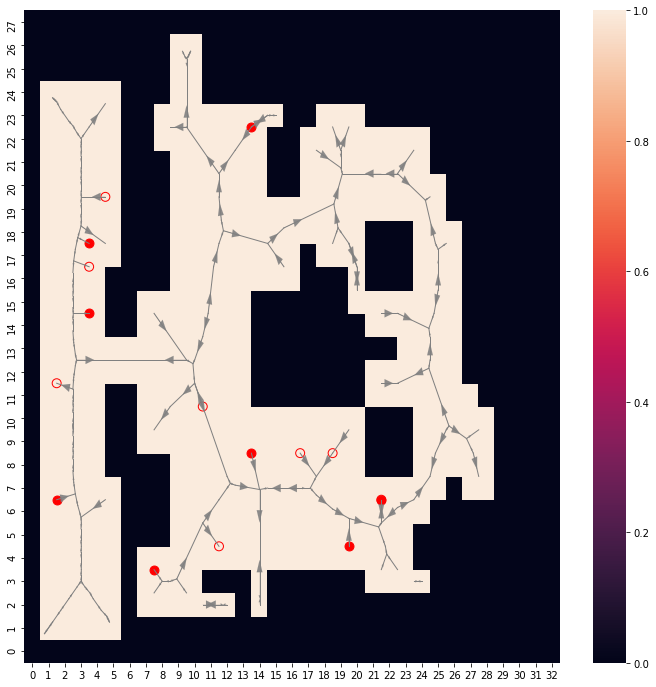

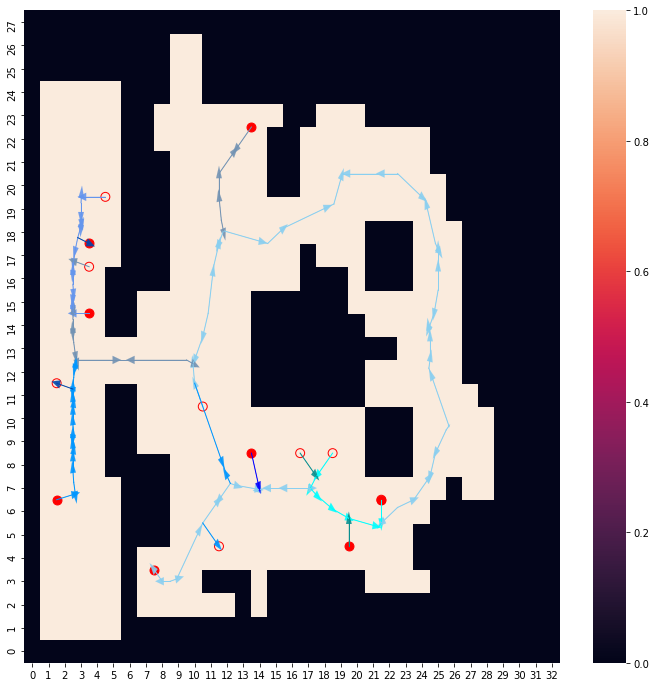

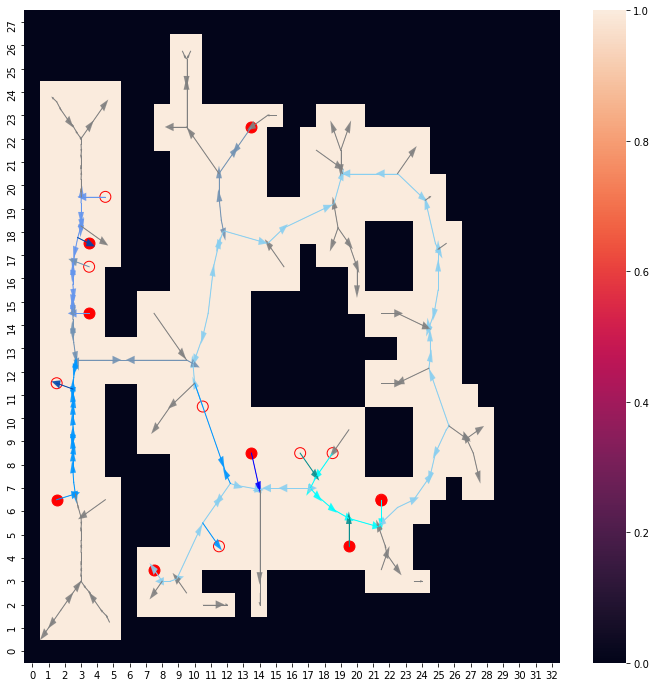

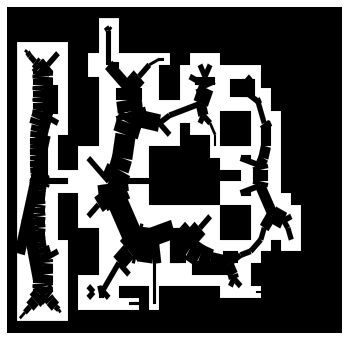

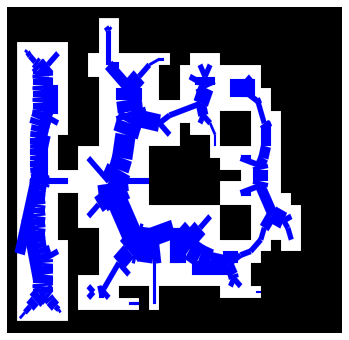

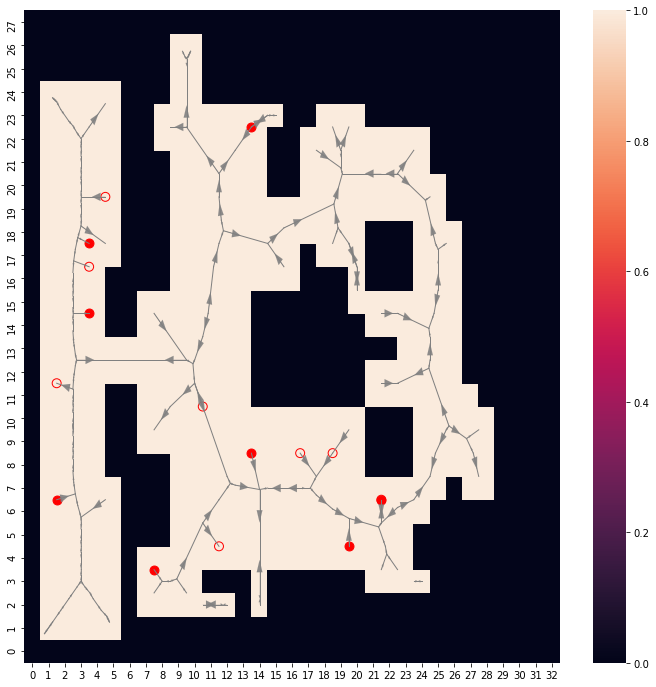

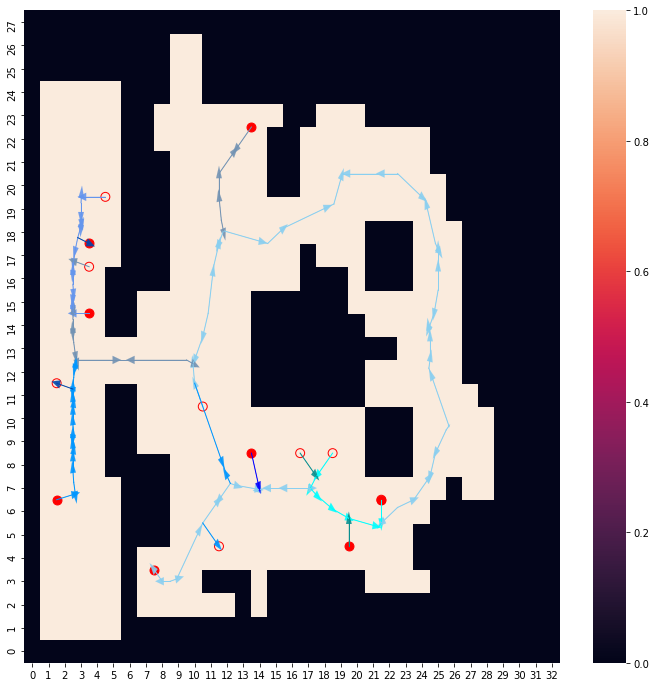

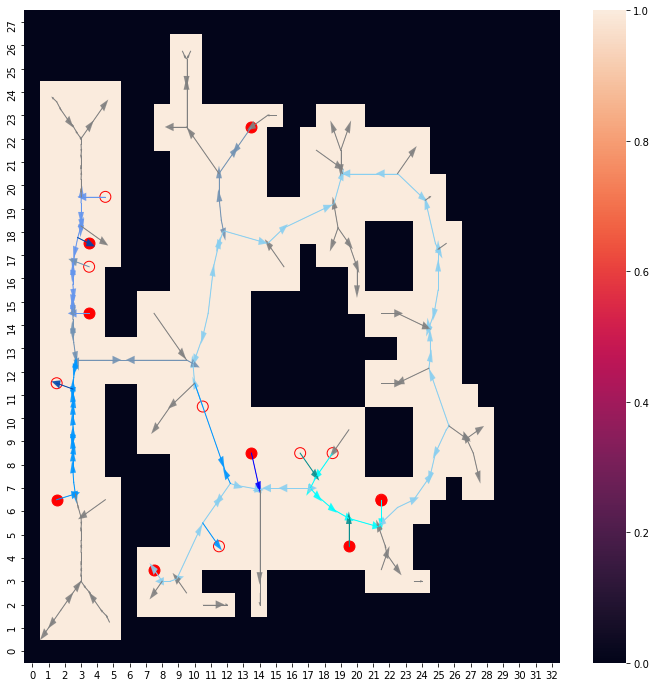

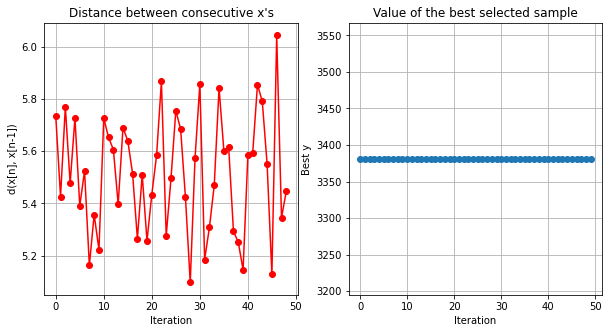

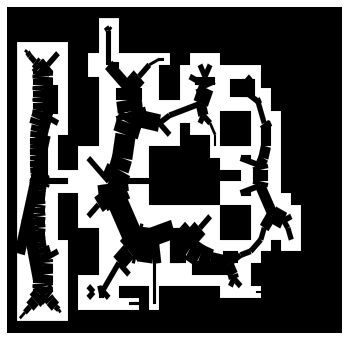

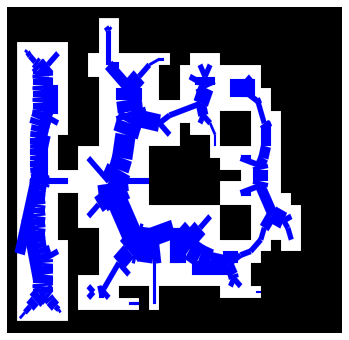

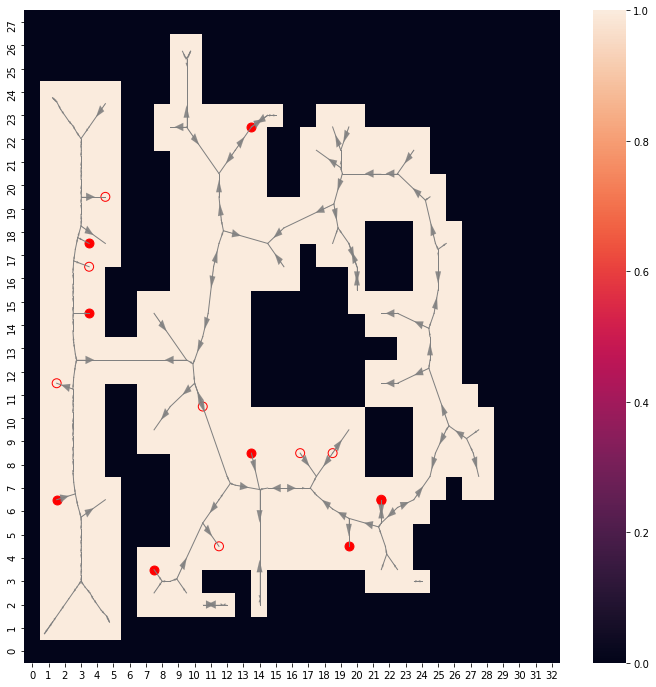

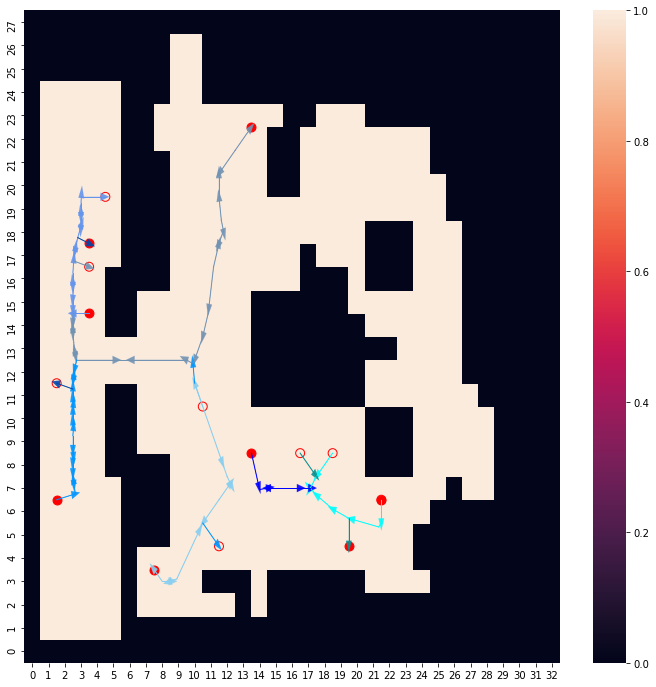

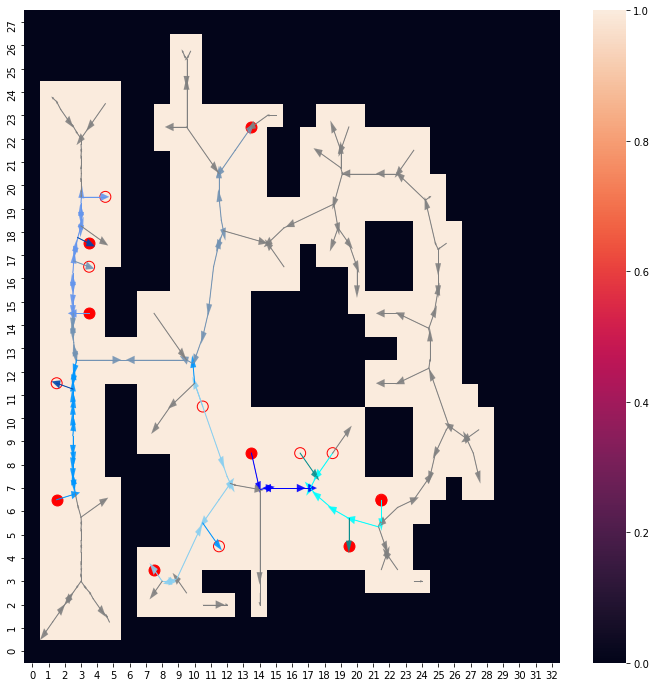

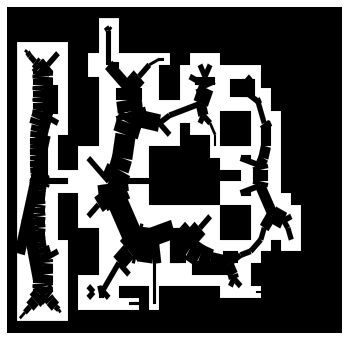

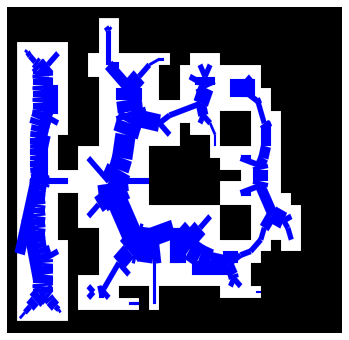

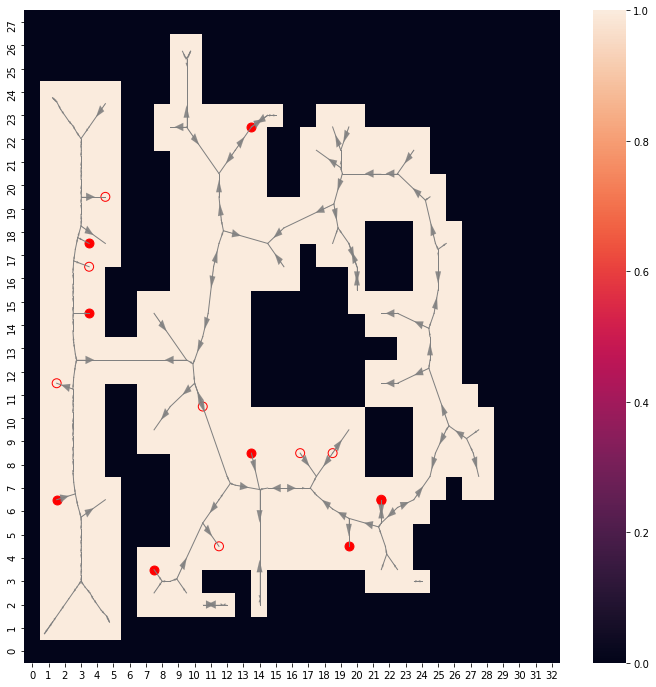

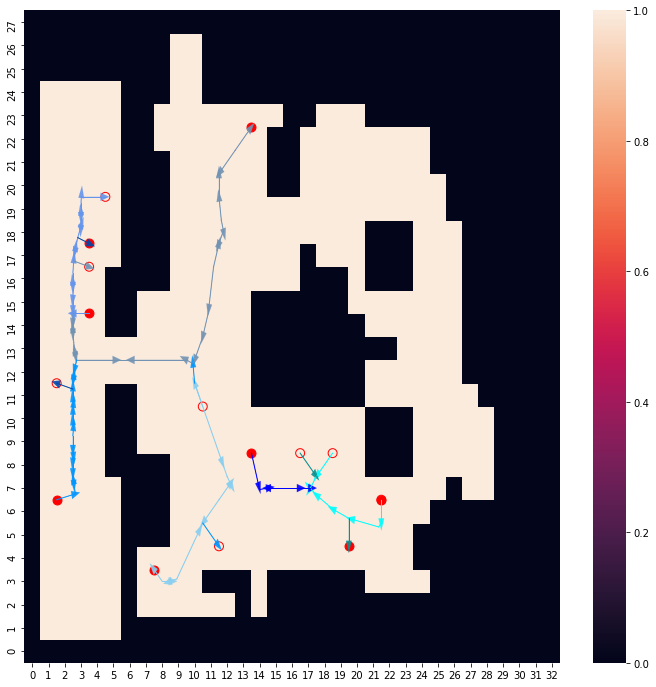

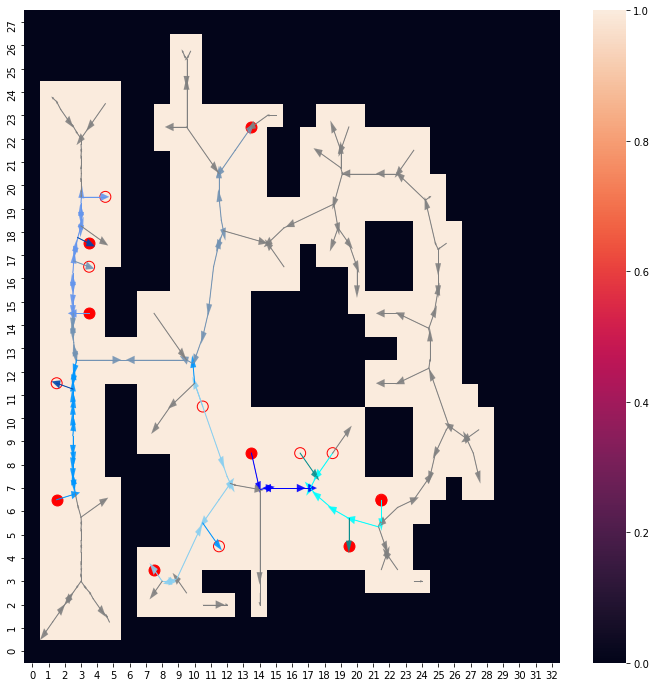

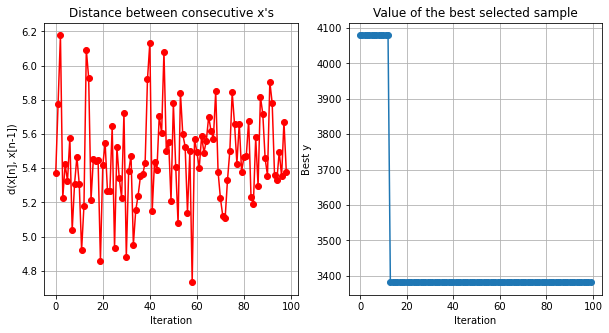

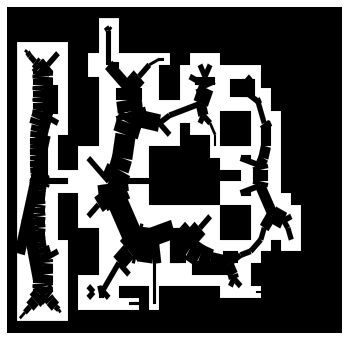

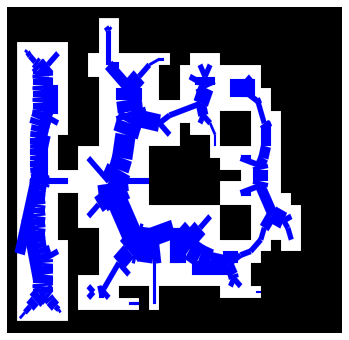

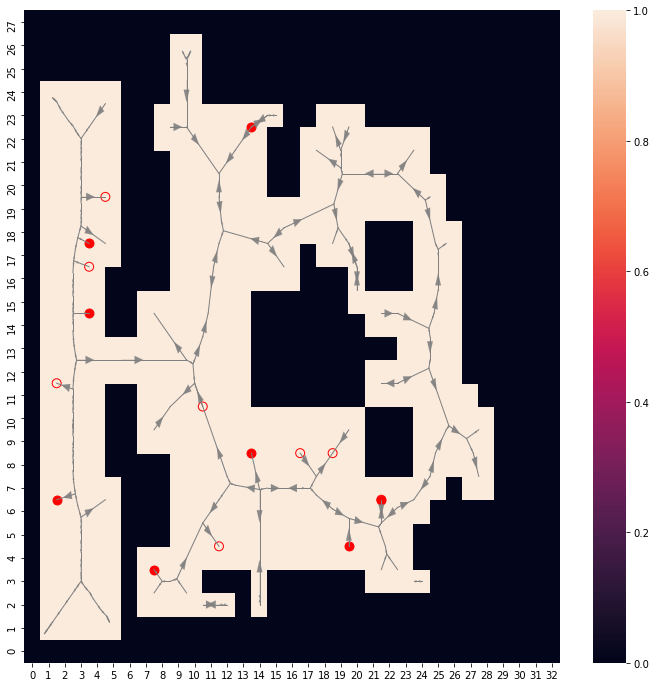

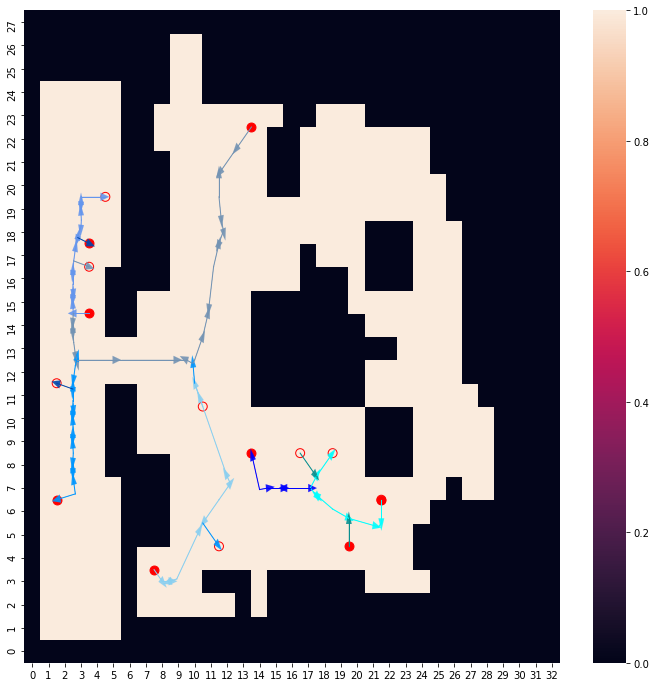

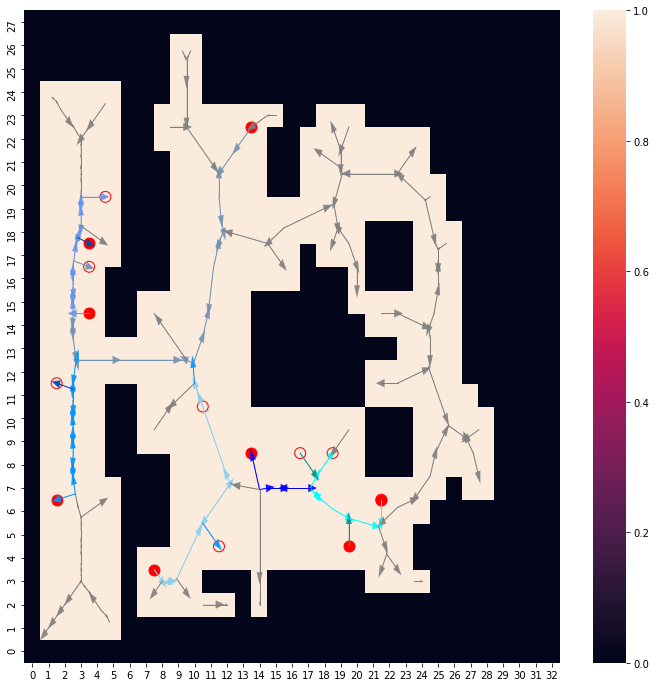

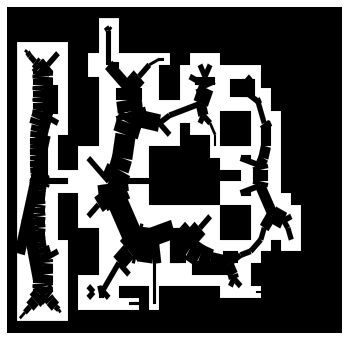

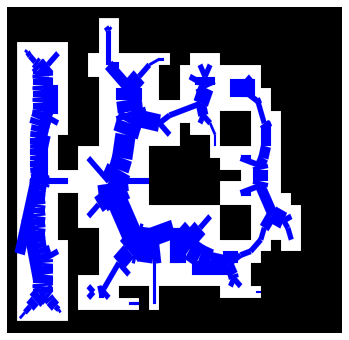

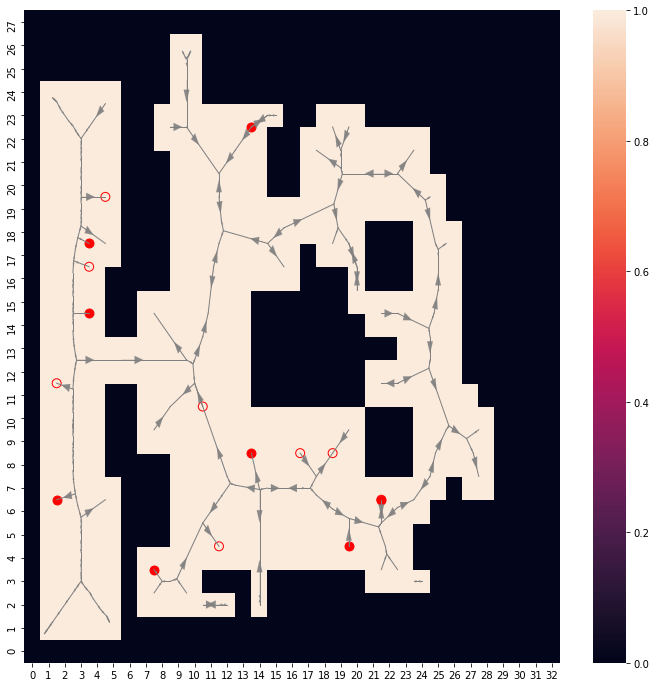

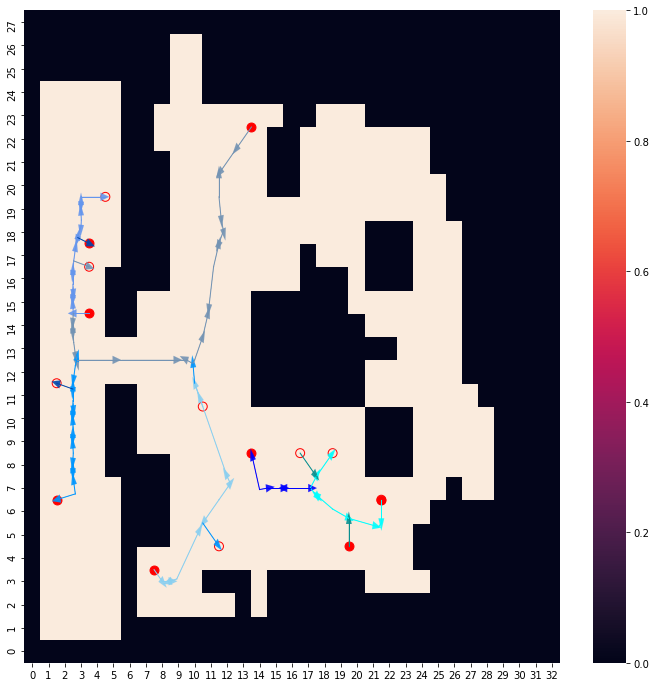

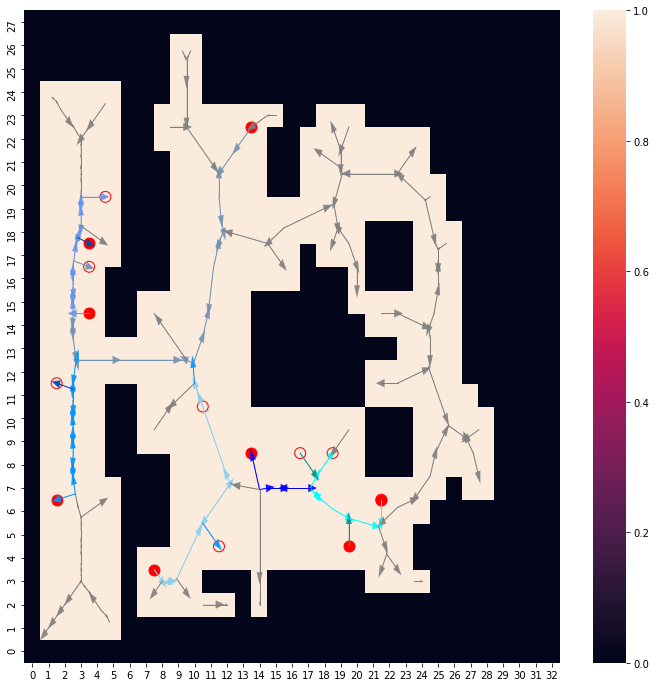

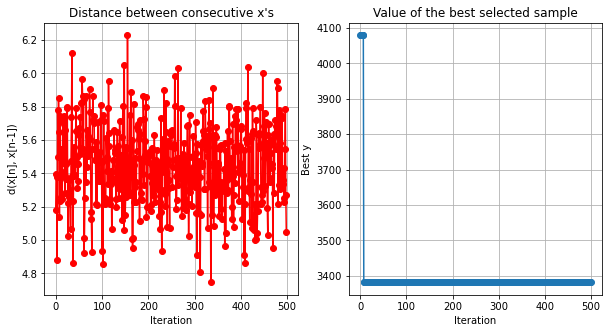

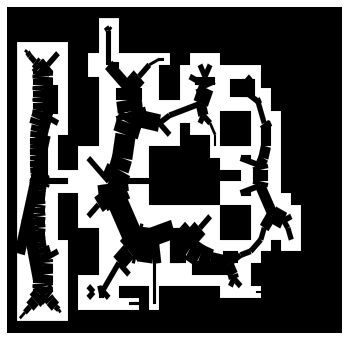

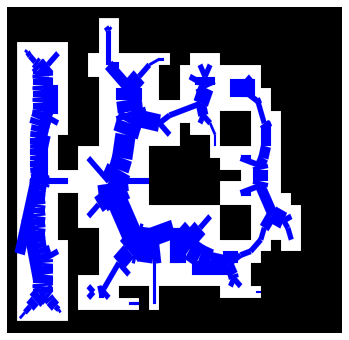

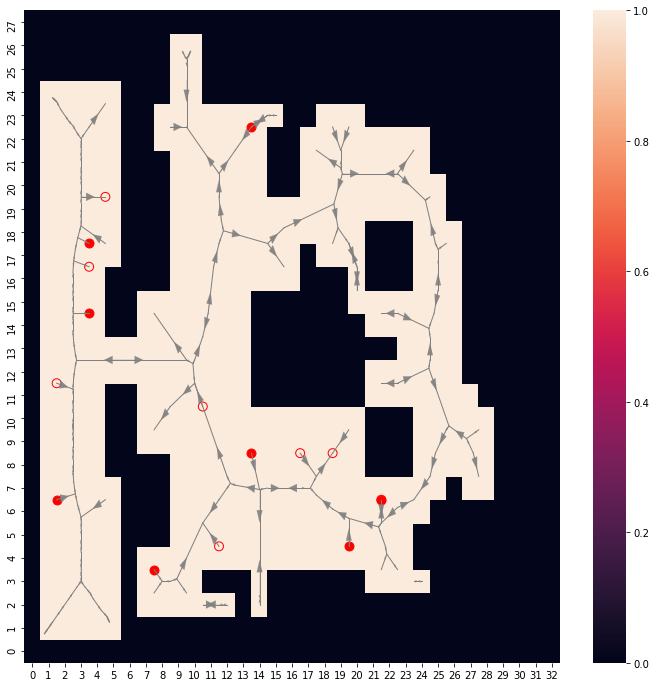

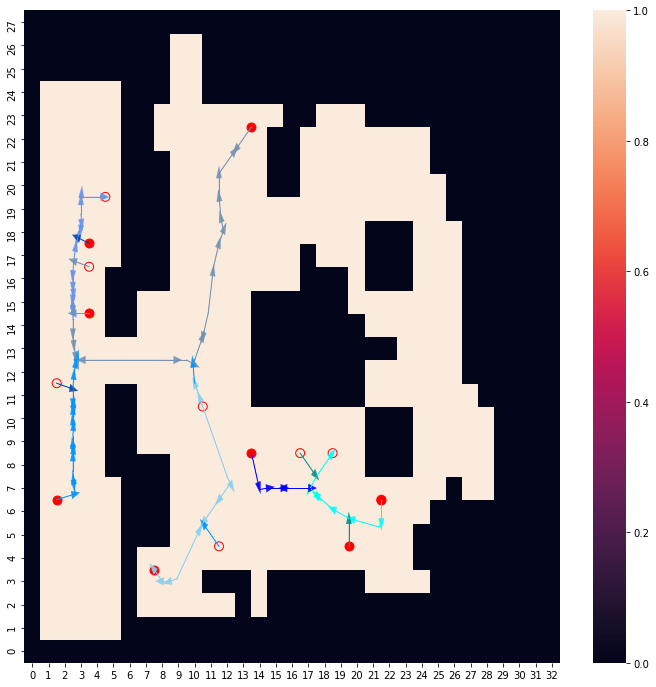

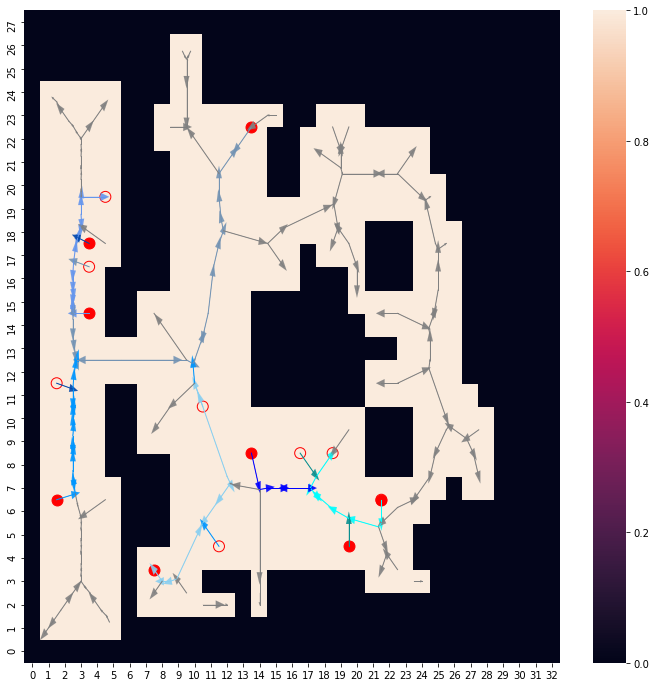

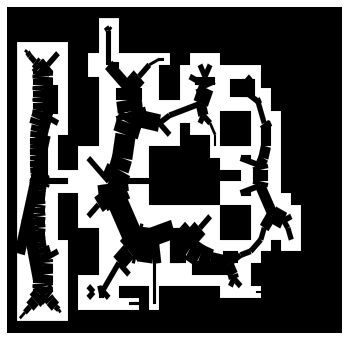

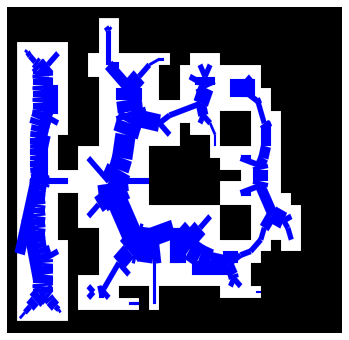

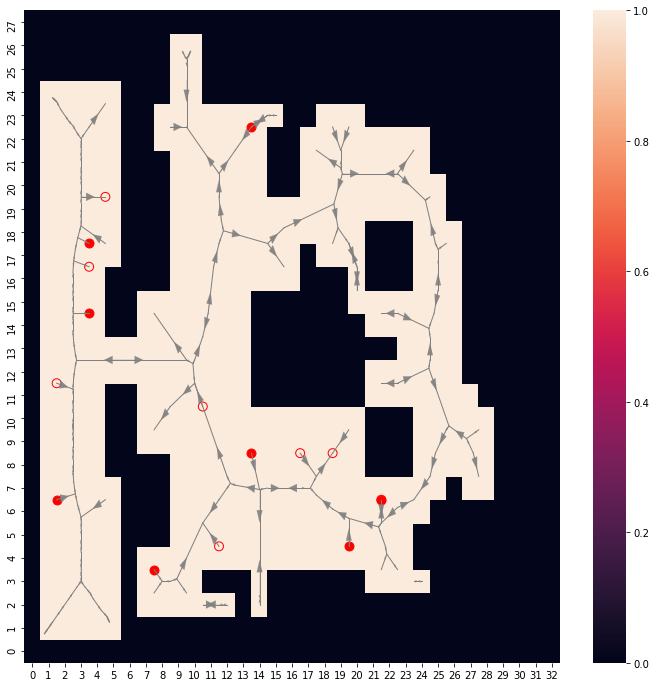

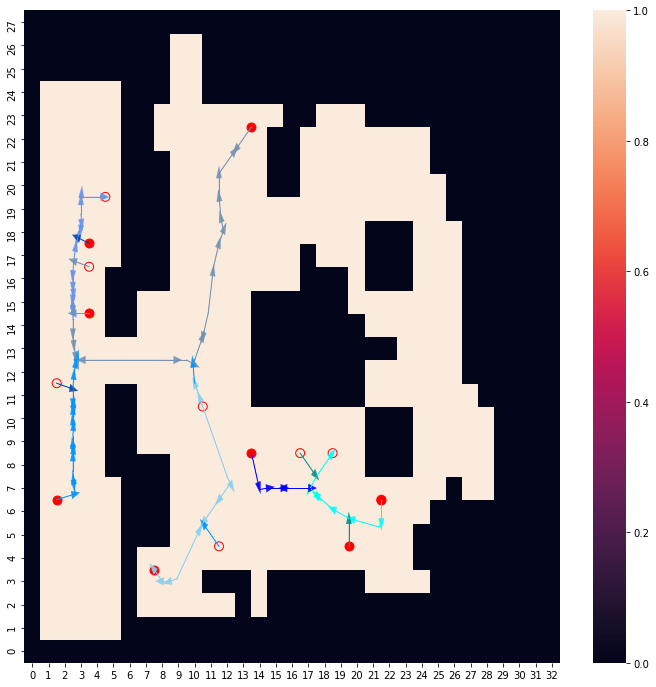

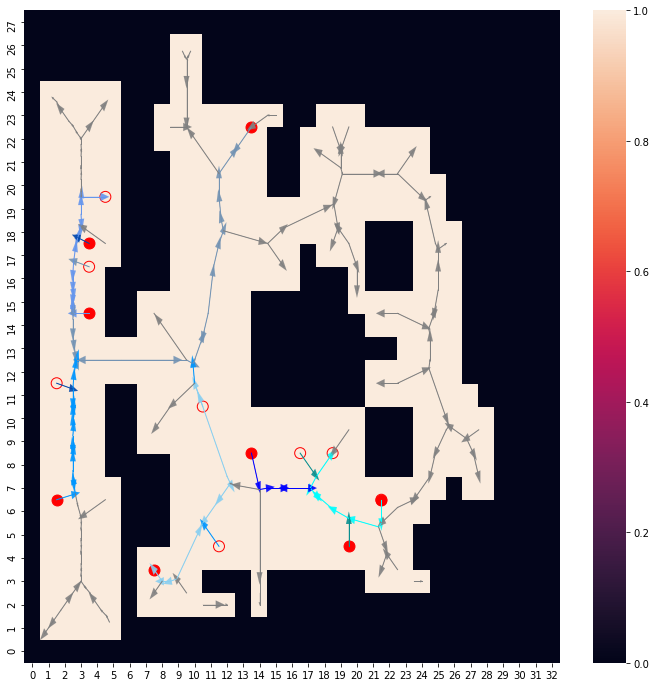

In [9]:
# sample_no_list =  [100]
sample_no_list =  [10,50,100,500]
# sample_no_list =  [10,50,100,500,1000]
for NUM_AGENT in agent_list:
    for NUM_SAMPLE in sample_no_list:
        for DATASET in range(3,4,1):

            try:
                overall_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/"
                os.makedirs(overall_path)
            except OSError:
                print ("Creation of the directory %s failed" % overall_path)
            else:
                print ("Successfully created the directory %s " % overall_path)

            opt_fig_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/optimiser_fig.png"
            result_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/result.csv"

            vordir_fig_pathonly_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) +"/vordir_paths.png"
            vordir_fig_alledge_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_alledge.png"
            vordir_fig_acc_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_acc.png"
            vordir_fig_coverage_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_coverage.png"
            vordir_path_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_path.csv"
            vordir_probability_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_prob.csv"
            # without sub graph
            vordir2_fig_pathonly_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_paths.png"
            vordir2_fig_alledge_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_alledge.png"
            vordir2_fig_acc_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_acc.png"
            vordir2_fig_coverage_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_coverage.png"
            vordir2_path_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_path.csv"
            vordir2_probability_path = "./data/BO/"+str(NUM_AGENT)+"agent/Samples"+ str(NUM_SAMPLE) + "/Dataset" + str(DATASET) + "/vordir_nosub_prob.csv"



            # Optimiser
#             scenemap = "./input/random-32-32-10/random-32-32-10.map"
#             scene = "./input/random-32-32-10/scen-even/random-32-32-10-even-" + str(DATASET) + ".scen"
#             exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective=OBJECTIVE, num_agent=NUM_AGENT)
            
            scene = "./input/same_density/"+ mapp +'/dataset/'+str(DATASET)+'_'+ mapp + ".scen"
            scenemap = "./input/same_density/"+ mapp +'/'+ mapp + ".map"
            exp = experiment.Experiment(scenemap=scenemap, scene=scene, objective= OBJECTIVE, num_agent=NUM_AGENT)


            start = time.time()
            opt, graph = bo2VoronoiDirected.bo2_voronoi_directed(exp, num_sample = NUM_SAMPLE)
            end = time.time()
            generate_data_time = end - start

            opt.plot_convergence(opt_fig_path)
            pd.DataFrame(opt.x_opt).to_csv(result_path, index=None)


            # Visualisation
            probabilities = opt.x_opt
    #         output = bo2VoronoiDirected.get_results(probabilities, exp)
    #         vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_con, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output
    #         vordir_u2 = getCoverage(exp,vordir_G, directed = True)


            vordir_m = probabilities[-3]
            vordir_c = probabilities[-2]
            output = bo2VoronoiDirected.get_results(probabilities, exp)
            vordir_paths, vordir_cost, vordir_ft, vordir_u1, vordir_u2, vordir_conwait, vordir_conmax, vordir_conavg, vordir_G0, vordir_G, vordir_thres, vordir_penality = output

            with open(vordir_path_path, 'a+') as f:
                paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir_paths) for t in path]
                paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                pd.DataFrame(paths_pd).to_csv(f, index=None)
            with open(vordir_probability_path, 'a+') as f:
                pd.DataFrame(probabilities).to_csv(f, index=None)

            vordir_u2 = getCoverage(exp, vordir_G, directed = True)
            getCoverage(exp,vordir_G, directed = True, save_fig_path=vordir_fig_coverage_path)
            showVorDirSolution(vordir_G, vordir_paths, exp, save_fig_path = vordir_fig_alledge_path)
            showVorDirSolutionPath(vordir_G, 
                                    vordir_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir_fig_pathonly_path) #path_num variables is unused
            showVorDirSolutionAcc(vordir_G, 
                                    vordir_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir_fig_acc_path, 
                                    exp=exp)


            # Voronoi Directed Without subgraph
            probabilities2 = copy.deepcopy(probabilities)
            probabilities2[-1] = 0
            output2 = bo2VoronoiDirected.get_results(probabilities, exp)
            vordir2_paths, vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_conavg, vordir2_G0, vordir2_G, vordir2_thres, vordir2_penality = output2
            vordir2_u2 = getCoverage(exp,vordir_G, directed = True)
            with open(vordir2_path_path, 'a+') as f:
                paths = [[idx, exp.nodes[t].x , exp.nodes[t].y] for idx, path in enumerate(vordir2_paths) for t in path]
                paths_pd = pd.DataFrame(paths,columns=['Agent', 'X','Y'])
                pd.DataFrame(paths_pd).to_csv(f, index=None)
            with open(vordir2_probability_path, 'a+') as f:
                pd.DataFrame(probabilities2).to_csv(f, index=None)
            getCoverage(exp,vordir2_G0, directed = True, save_fig_path=vordir2_fig_coverage_path)
            showVorDirSolution(vordir2_G0, vordir2_paths, exp, save_fig_path = vordir2_fig_alledge_path)
            showVorDirSolutionPath(vordir2_G0, 
                                    vordir2_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir2_fig_pathonly_path) #path_num variables is unused
            showVorDirSolutionAcc(vordir2_G0, 
                                    vordir2_paths, 
                                    exp.image, 
                                    exp.nodes, 
                                    exp.start_nodes, 
                                    exp.end_nodes, 
                                    all_path = False, 
                                    path_num = 0,
                                    save_fig_path = vordir2_fig_acc_path, 
                                    exp=exp)


            results = [NUM_AGENT, NUM_SAMPLE, DATASET, vordir_cost, 
                       vordir_ft, vordir_u1, vordir_u2, vordir_penality,
                       vordir_conwait, vordir_conmax, vordir_thres, vordir_m, vordir_c,
                       vordir2_cost, vordir2_ft, vordir2_u1, vordir2_u2, vordir2_conwait, vordir2_conmax, vordir2_penality,
                       generate_data_time]

            results_array.append(results)

            result_pd = pd.DataFrame([results],columns=['Agent','Samples','Dataset','vordir_cost',
                                                        'vordir_ft', 'vordir_u1', 'vordir_u2', 'vordir_penality',
                                                        'vordir_conwait', 'vordir_conmax', 'vordir_thres', 'vordir_m', 'vordir_c',
                                                        'vordir2_cost', 'vordir2_ft', 'vordir2_u1', 'vordir2_u2', 'vordir2_conwait', 'vordir2_conmax', 'vordir2_penality',
                                                        'Time'])

            with open(final_result_path, 'a+') as f:
                    pd.DataFrame(result_pd).to_csv(f, index=None)

In [10]:
pd.DataFrame(results_array,columns=['Agent','Samples','Dataset','vordir_cost',
                                    'vordir_ft', 'vordir_u1', 'vordir_u2', 'vordir_penality',
                                    'vordir_conwait', 'vordir_conmax', 'vordir_thres', 'vordir_m', 'vordir_c',
                                    'vordir2_cost', 'vordir2_ft', 'vordir2_u1', 'vordir2_u2', 'vordir2_penality',
                                    'Time'])

Agent  Samples  Dataset  vordir_cost  vordir_ft  vordir_u1  vordir_u2  \
0      8      500        2    81.019667  28.379134   0.349275   0.136957   
1      8      500        3    80.637289  35.483155   0.439034   0.135504   
2      8      500        4    80.414819  19.596015   0.242687   0.162880   
3      8      500        5    84.676852  36.400539   0.428876   0.143577   

   vordir_penality  vordir_conmax  vordir_conavg  vordir_thres  vordir_m  \
0              0.0            2.0          0.125      0.439567 -0.475723   
1              0.0            2.0          0.125      0.299721 -0.151312   
2              0.0            2.0          0.125      0.313034 -0.448726   
3              0.0            2.0          0.125      0.429868  0.155991   

   vordir_c  vordir2_cost  vordir2_ft  vordir2_u1  vordir2_u2  \
0  0.508105     81.019667   28.379134    0.349275    0.136957   
1  0.314626     80.637289   35.483155    0.439034    0.135504   
2  0.468009     80.414819   19.596015    0.242687    0.162880   
3  0.390255     84.676852   36.400539    0.428876    0.143577   

   vordir2_penality          Time  
0               0.0   1465.497404  
1               0.0   2125.711916  
2               0.0   1168.939971  
3               0.0  13522.391203